### **Detecção de Fraudes em Sinistros de Seguros Automotivos**

A fraude em seguros de veículos envolve a conspiração para fazer reivindicações falsas ou exageradas relacionadas a danos materiais ou lesões corporais após um acidente. Alguns exemplos comuns incluem acidentes simulados, nos quais os fraudadores deliberadamente "planejam" que acidentes ocorram; o uso de passageiros fantasmas, em que pessoas que nem estavam no local do acidente alegam ter sofrido ferimentos graves; e a apresentação de falsas reivindicações de danos pessoais, nas quais as lesões são grosseiramente exageradas.

Sobre este conjunto de dados

Este conjunto de dados contém informações sobre veículos — atributos, modelo, detalhes de acidentes, etc. — juntamente com detalhes da apólice — tipo de apólice, duração, etc. O objetivo é detectar se uma solicitação de indenização é fraudulenta ou não — FraudFound_P


# Importando as bibliotecas

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Leitura do dataset

In [3]:
df = pd.read_csv("fraud_oracle.csv")
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [4]:
pd.set_option('display.max_columns', None)


# **Explicação das Colunas**

**Informações temporais**
* Month - Mês em que o acidente ocorreu                        
* WeekOfMonth - Semana do mês do acidente                               
* DayOfWeek - Dia da semana do acidente
* DayOfWeekClaimed - Dia da semana em que o sinistro foi registrado.
* MonthClaimed - Mês em que o cliente entrou com a reclamação do seguro.
* WeekOfMonthClaimed - Semana do mês em que a reclamação foi registrada. 
* Year - Ano do registro do caso.

**Informações sobre o veículo**
* Make - Fabricante do carro (Honda, Toyota, etc.)   
* NumberOfCars - Número de carros que o segurado possui.
* AgeOfVehicle - Idade do veículo (ex.: “3 years”, “more than 7”).   
* VehicleCategory - Categoria do veículo (ex.: Sedan, SUV, Sports car, Utility, Van)
* VehiclePrice - Preço/valor do veículo       
     
**Informações sobre o acidente**
* AccidentArea -  Local do acidente (Urban ou Rural).  
* PoliceReportFiled - Indica se boletim policial foi registrado (Yes/No).
* WitnessPresent - Se havia testemunha presente (Yes/No).
* Fault - Culpado pelo acidente (ex.: Policy Holder, Third Party, Unknown, Not At Fault).

**Informações sobre o segurado**
* Sex - Sexo do segurado (Male/Female).
* MaritalStatus - Estado civil (Single, Married, etc.).
* Age - Idade do segurado.
* AgeOfPolicyHolder - Faixa etária do segurado (ex.: “26 to 30”).
* AgentType - Tipo do agente de atendimento (Internal/External).

**Histórico de apólice e comportamento**
* Days_Policy_Accident - Tempo entre emissão da apólice e o acidente
* Days_Policy_Claim - Tempo entre emissão da apólice e abertura da reclamação.
* PastNumberOfClaims - Número de sinistros anteriores do segurado.
* NumberOfSuppliments - Número de reavaliações adicionais no processo de sinistro.
* AddressChange_Claim - Tempo desde a última mudança de endereço.
* BasePolicy -  Tipo de cobertura fundamental que acompanha a apólice (Liability, Collision, etc.).
* PolicyType - Tipo de apólice (ex.: Private, Commercial, Corporate, Special)
* PolicyNumber -  Número único da apólice / identificador do cliente.

**Valores e características do processo**
* RepNumber - Identificação do representante ou agente.
* Deductible - Franquia que o cliente deve pagar.
* DriverRating - Nota de risco do motorista (1–4, geralmente).
* FraudFound_P -  Indicador de fraude encontrada/presumida para aquele sinistro 





# Análise Exploratória

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

### **Quantidade de Linhas e Colunas no DataSet**

In [6]:
print(f'O dataset possui {df.shape[0]} de linhas')
print(f'O dataset possui {df.shape[1]} de colunas')

O dataset possui 15420 de linhas
O dataset possui 33 de colunas


### Verificando se existem dados nulos

In [7]:
# Quantidade de nulos por coluna
null_count = df.isnull().sum()

# Porcentagem de nulos por coluna
null_percent = (df.isnull().sum() / len(df)) * 100

# Criando novo DataFrame apenas com colunas que possuem nulos
df_nulos = pd.DataFrame({
    'Quantidade de Nulos': null_count,
    'Percentual (%)': null_percent
})

# Filtrar apenas onde há nulos
df_nulos = df_nulos[df_nulos['Quantidade de Nulos'] > 0]

# Ordenar do maior para o menor percentual
df_nulos = df_nulos.sort_values(by='Percentual (%)', ascending=False)

df_nulos

,Quantidade de Nulos,Percentual (%)


Com base no estudo acima, podemos verificar que o dataset não possui nenhum valor nulo

### Verificando se existem valores duplicados

In [8]:
duplicatas = df.duplicated().sum()
print(f"Quantidade de linhas duplicadas: {duplicatas}")
df[df.duplicated()]

Quantidade de linhas duplicadas: 0


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy


Com base no estudo acima, vemos que o dataset não conta com informações duplicadas

### Principais estatísticas das colunas numéricas

In [9]:
df.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


### Verificando informações da coluna Age

In [10]:
display(df['Age'].describe())

print("\n")
media = df['Age'].mean()
mediana = df['Age'].median()
moda = df['Age'].mode()[0]

print("Média:", media)
print("Mediana:", mediana)
print("Moda:", moda)

count    15420.000000
mean        39.855707
std         13.492377
min          0.000000
25%         31.000000
50%         38.000000
75%         48.000000
max         80.000000
Name: Age, dtype: float64



Média: 39.855706874189366
Mediana: 38.0
Moda: 30


# **Análise Univariada**

## Distribuição das variáveis

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Deductible'}>],
       [<Axes: title={'center': 'DriverRating'}>, <Axes: >]], dtype=object)

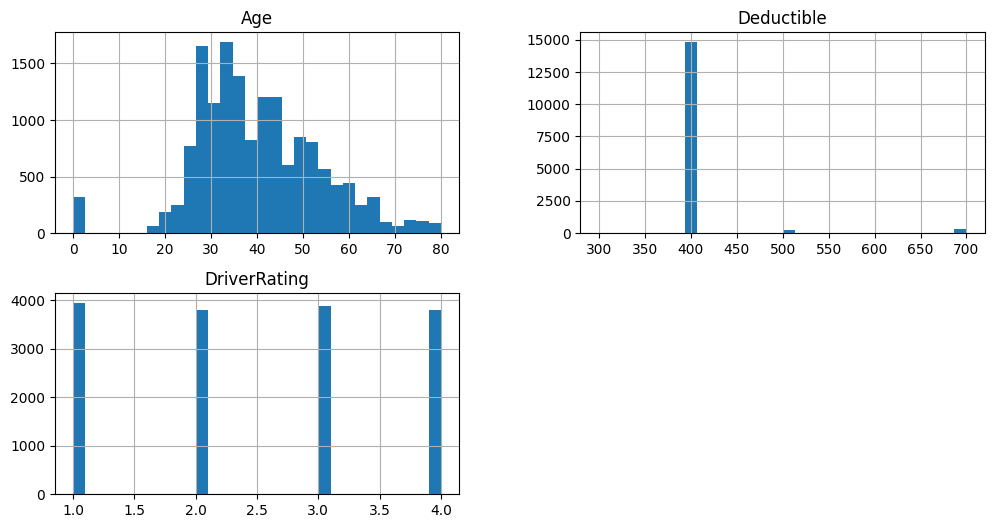

In [11]:
df_analisys = df.drop(columns=['WeekOfMonth', 'WeekOfMonthClaimed',
                               'FraudFound_P', 'PolicyNumber', 'Year', 'RepNumber'])  # remove só para analisar

df_analisys.hist(figsize=(12, 6), bins=30)
 

Limitei o df nessas 3 colunas, pois as demais colunas numéricas, possuem dados como identificação de mês e semana, ano e identificação de representante. Esses dados não são dados significativos para este tipo de análise. Somente para identificação dos casos. 

## Verificando se existem Outliers no dataset

In [12]:
# Selecionar apenas colunas numéricas
df_num = df.select_dtypes(include=['float64', 'int64'])

# Calcular assimetria e curtose
skew_vals = df_num.skew()
kurt_vals = df_num.kurt()

# Criar DataFrame consolidado
stats_dist = pd.DataFrame({
    'Skewness (Assimetria)': skew_vals,
    'Kurtosis (Curtose)': kurt_vals
}).sort_values(by='Skewness (Assimetria)', ascending=False)

# Exibir apenas o resultado final formatado
display(stats_dist)

print("""
• Skewness > 0   →   distribuição com cauda longa à direita.
• Skewness < 0   →   cauda longa à esquerda.
• Curtose  > 0   →   presença de valores extremos (outliers).
""")

,Skewness (Assimetria),Kurtosis (Curtose)
Deductible,6.078803,36.822777
FraudFound_P,3.711164,11.774267
Year,0.245689,-1.410715
WeekOfMonthClaimed,0.158233,-1.085554
Age,0.152314,0.798666
WeekOfMonth,0.115426,-1.101157
DriverRating,0.009283,-1.363286
RepNumber,0.006628,-1.191876
PolicyNumber,0.000000,-1.200000



• Skewness > 0   →   distribuição com cauda longa à direita.
• Skewness < 0   →   cauda longa à esquerda.
• Curtose  > 0   →   presença de valores extremos (outliers).



Podemos notar que a coluna Deductible possui valores extremos, porém como se trata de informações sobre valores da franquia a ser paga, acredito que não seja um agravame esse caso.

### **Análise Bivariada**

### **Matriz de Correlação - Relações entre Variáveis**

Colunas numéricas incluídas na correlação (9):
['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'FraudFound_P', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Year']


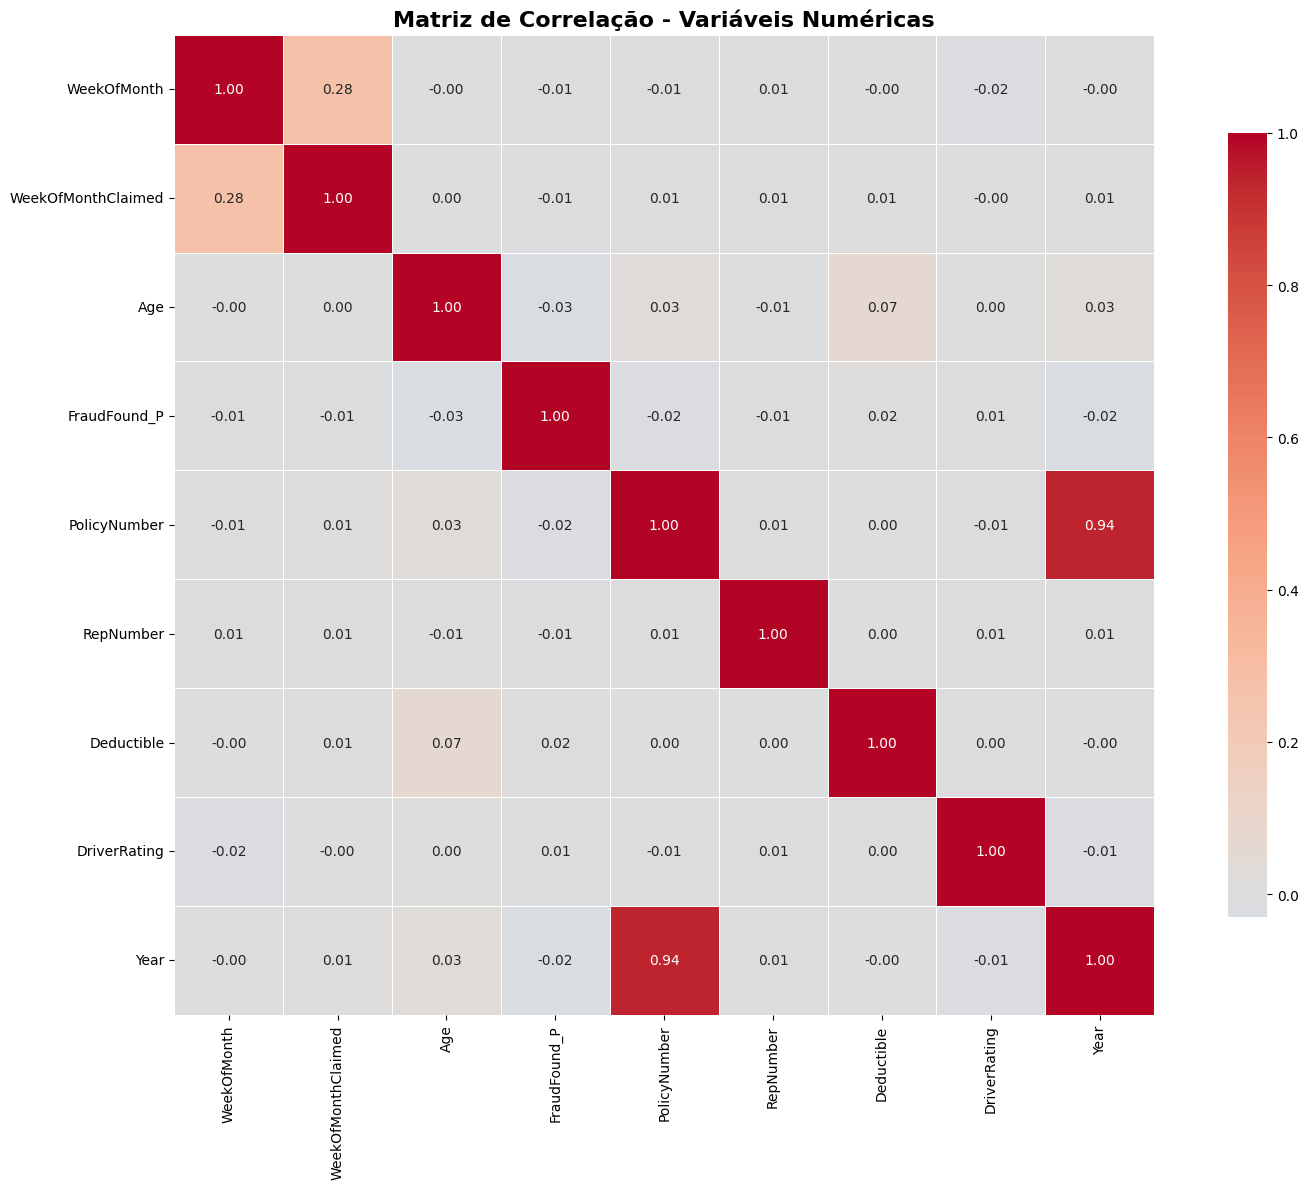


Variáveis mais correlacionadas com Fraude (FraudFound_P):


Deductible            0.017348
DriverRating          0.007266
WeekOfMonthClaimed   -0.005761
RepNumber            -0.007551
WeekOfMonth          -0.011861
PolicyNumber         -0.020345
Year                 -0.024760
Age                  -0.029741
Name: FraudFound_P, dtype: float64

In [13]:
# Selecionar apenas variáveis VERDADEIRAMENTE numéricas
# Isso automaticamente exclui categóricas (object dtype)
df_numeric = df.select_dtypes(include=['float64', 'int64'])

print(f"Colunas numéricas incluídas na correlação ({len(df_numeric.columns)}):")
print(df_numeric.columns.tolist())

# Calcular matriz de correlação
correlation_matrix = df_numeric.corr()

# Criar figura com tamanho adequado
plt.figure(figsize=(16, 12))

# Criar heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,  # Mostrar valores
    fmt='.2f',   # Formato com 2 casas decimais
    cmap='coolwarm',  # Paleta de cores
    center=0,    # Centralizar em 0
    square=True, # Células quadradas
    linewidths=0.5,  # Linhas entre células
    cbar_kws={'shrink': 0.8}  # Ajustar barra de cores
)

plt.title('Matriz de Correlação - Variáveis Numéricas', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Exibir correlações com FraudFound_P ordenadas
print("\nVariáveis mais correlacionadas com Fraude (FraudFound_P):")
fraud_correlations = correlation_matrix['FraudFound_P'].drop('FraudFound_P').sort_values(ascending=False)
display(fraud_correlations)

A matriz de correlação revela informações importantes sobre as relações entre as variáveis numéricas do dataset. Com base na análise acima, podemos verificar que as variáveis com maior correlação positiva com fraude (FraudFound_P) são aquelas que apresentam valores mais próximos de 1 ou -1. Essas variáveis serão fundamentais para a etapa de feature engineering e seleção de features na modelagem, pois indicam quais características têm maior poder preditivo para identificar casos fraudulentos. Além disso, a matriz nos permite identificar multicolinearidade entre variáveis independentes, o que pode ser importante para evitar redundância no modelo.

### **Verificando a quantidade de fraudes**

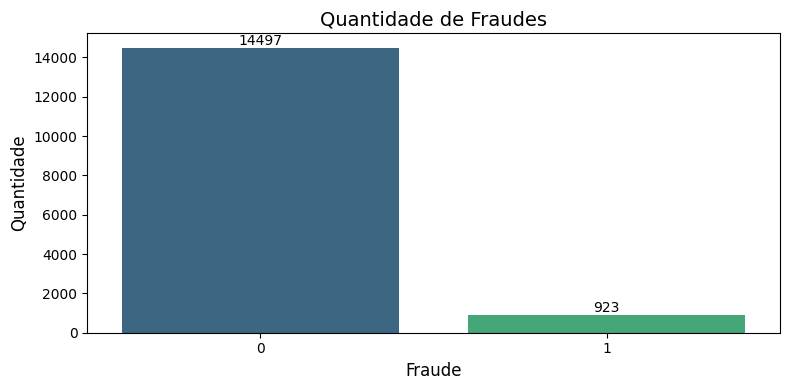

In [14]:
contagem = df['FraudFound_P'].value_counts().reset_index()
contagem.columns = ['FraudFound_P', 'Frequência']
 
plt.figure(figsize=(8, 4))
 
ax = sns.barplot(
    x='FraudFound_P',
    y='Frequência',
    data=contagem,
    palette='viridis',
    hue='FraudFound_P' # Corrigindo o warning de depreciação
)
 

# Adicionar Rótulos de Dados (Frequência)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')
 
plt.title('Quantidade de Fraudes', fontsize=14)
plt.xlabel('Fraude', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xticks(rotation=0)
 
# Ocultar a legenda (Correção alternativa ao erro)
if ax.legend_:
    ax.legend_.remove()
 
plt.tight_layout()
plt.show()

Com base nesse gráfico, podemos verificar que entre os 15420 dados levantados, apenas 923 foram apontados como fraude

Contagem de fraudes em porcentagem:
FraudFound_P
0    14497
1      923
Name: count, dtype: int64 



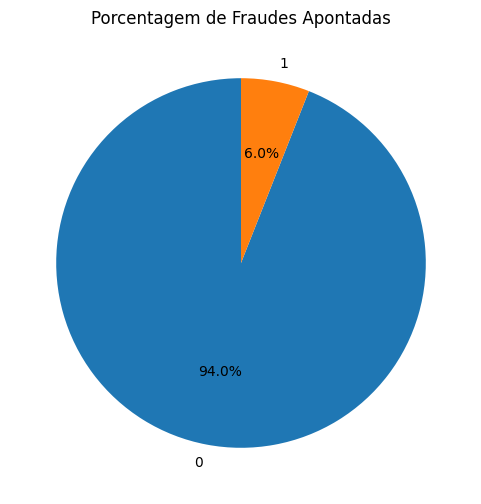

In [15]:
# Contagem de status
status_counts = df['FraudFound_P'].value_counts()

print("Contagem de fraudes em porcentagem:")
print(status_counts, "\n")

# Gráfico de pizza
plt.figure(figsize=(6,6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Porcentagem de Fraudes Apontadas")
plt.show()

Apenas 6% dos dados inputados são mostrados como positivo para fraude

# Verificando a frequencia de idade apresentada

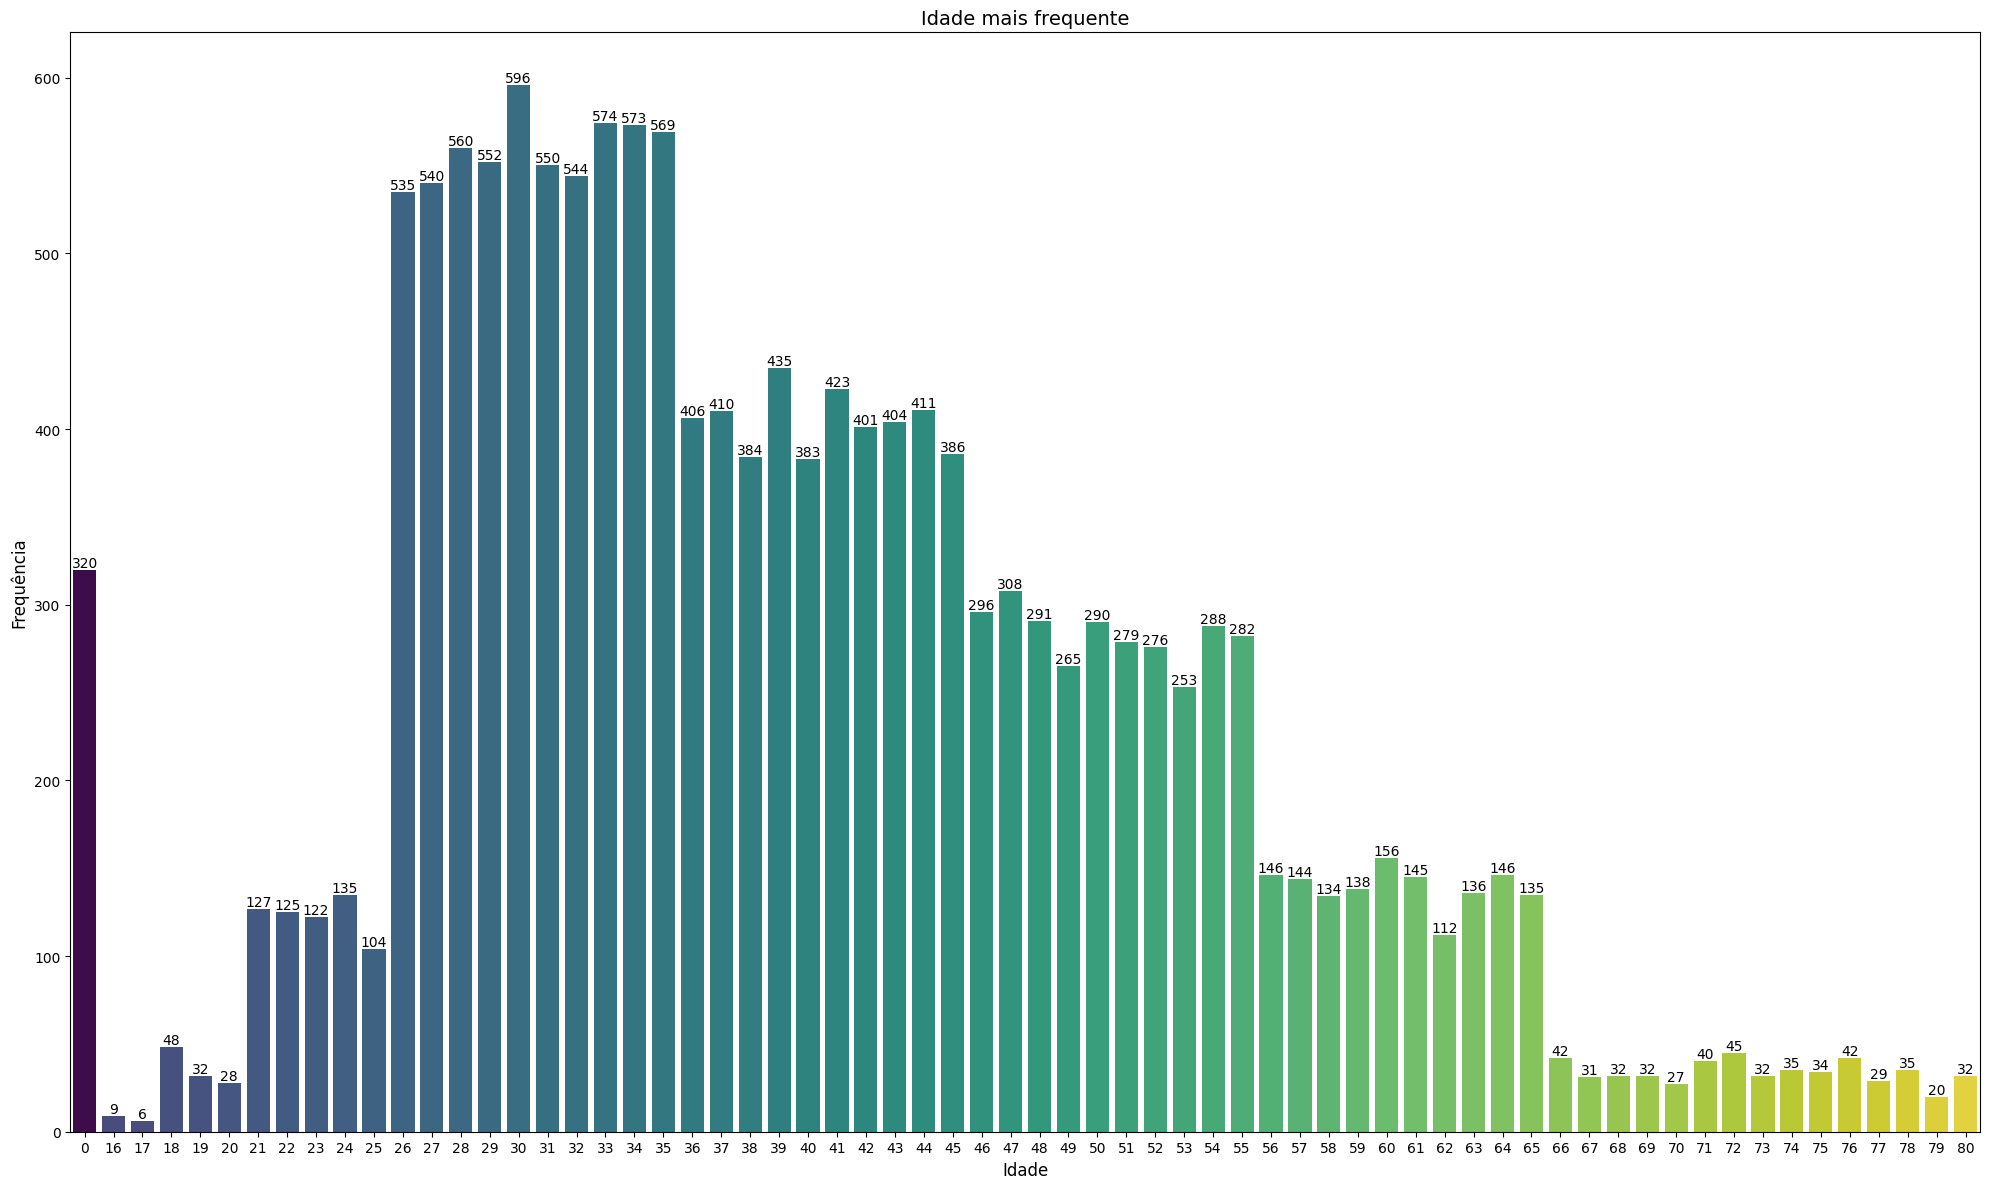

In [16]:
contagem_idade = df['Age'].value_counts().reset_index()
contagem_idade.columns = ['Age', 'Frequência']
 
plt.figure(figsize=(20, 12))
 
ax = sns.barplot(
    x='Age',
    y='Frequência',
    data=contagem_idade,
    palette='viridis',
    hue='Age' # Corrigindo o warning de depreciação
)
 

# Adicionar Rótulos de Dados (Frequência)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')
 
plt.title('Idade mais frequente', fontsize=14)
plt.xlabel('Idade', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.xticks(rotation=0)
 
# Ocultar a legenda (Correção alternativa ao erro)
if ax.legend_:
    ax.legend_.remove()
 
plt.tight_layout()
plt.show()

Podemos verificar que a faixa etária mais apresentada no dataset se concentra nas idades entre 26 e 35 anos. Porém, temos uma informação interessante, a idade de 0 anos está sendo apresentada 320 vezes. 

### **Verificando informação com idade 0**

In [17]:
df[df['Age'] == 0]

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
7,Nov,1,Friday,Honda,Urban,Tuesday,Mar,4,Male,Single,0,Policy Holder,Sport - Collision,Sport,more than 69000,0,8,1,400,4,more than 30,more than 30,1,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
13,Jan,5,Friday,Honda,Rural,Wednesday,Feb,1,Male,Single,0,Third Party,Sedan - Collision,Sedan,more than 69000,0,14,12,400,3,more than 30,more than 30,none,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
28,Jul,1,Saturday,Honda,Urban,Tuesday,Sep,4,Male,Single,0,Policy Holder,Sedan - All Perils,Sedan,more than 69000,1,29,9,400,1,more than 30,more than 30,none,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils
31,Mar,1,Sunday,Honda,Urban,Tuesday,Mar,2,Male,Single,0,Policy Holder,Sedan - Collision,Sedan,more than 69000,0,32,6,400,1,more than 30,more than 30,1,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
58,May,1,Monday,Honda,Rural,Wednesday,May,4,Male,Single,0,Policy Holder,Sedan - Liability,Sport,more than 69000,0,59,15,400,4,more than 30,more than 30,none,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Liability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15243,May,2,Tuesday,Honda,Urban,Monday,May,3,Male,Single,0,Policy Holder,Sedan - Liability,Sport,more than 69000,0,15244,7,400,3,more than 30,more than 30,none,new,16 to 17,No,No,External,none,no change,1 vehicle,1996,Liability
15262,Mar,3,Monday,Honda,Urban,Thursday,Mar,3,Male,Single,0,Policy Holder,Sedan - Liability,Sport,more than 69000,0,15263,5,400,3,more than 30,more than 30,more than 4,new,16 to 17,No,No,External,none,no change,1 vehicle,1996,Liability
15274,Apr,3,Monday,Honda,Urban,Tuesday,May,1,Male,Single,0,Third Party,Sedan - Collision,Sedan,more than 69000,0,15275,1,400,2,more than 30,more than 30,more than 4,new,16 to 17,No,No,External,none,no change,1 vehicle,1996,Collision
15379,Jan,2,Tuesday,Honda,Urban,Thursday,Jan,2,Male,Single,0,Policy Holder,Utility - All Perils,Utility,more than 69000,0,15380,1,400,3,more than 30,more than 30,more than 4,new,16 to 17,No,No,External,none,1 year,1 vehicle,1996,All Perils


Podemos notar que apesar da informação de idade estar com o valor 0, ela não tem correlação com somente casos de fraudes, indicando apenas um possível esquecimento de preenchimento.

### **Verificando a idade mais frequente nos casos de fraude**

C:\Users\Aleksander\AppData\Local\Temp\ipykernel_17828\2287872199.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


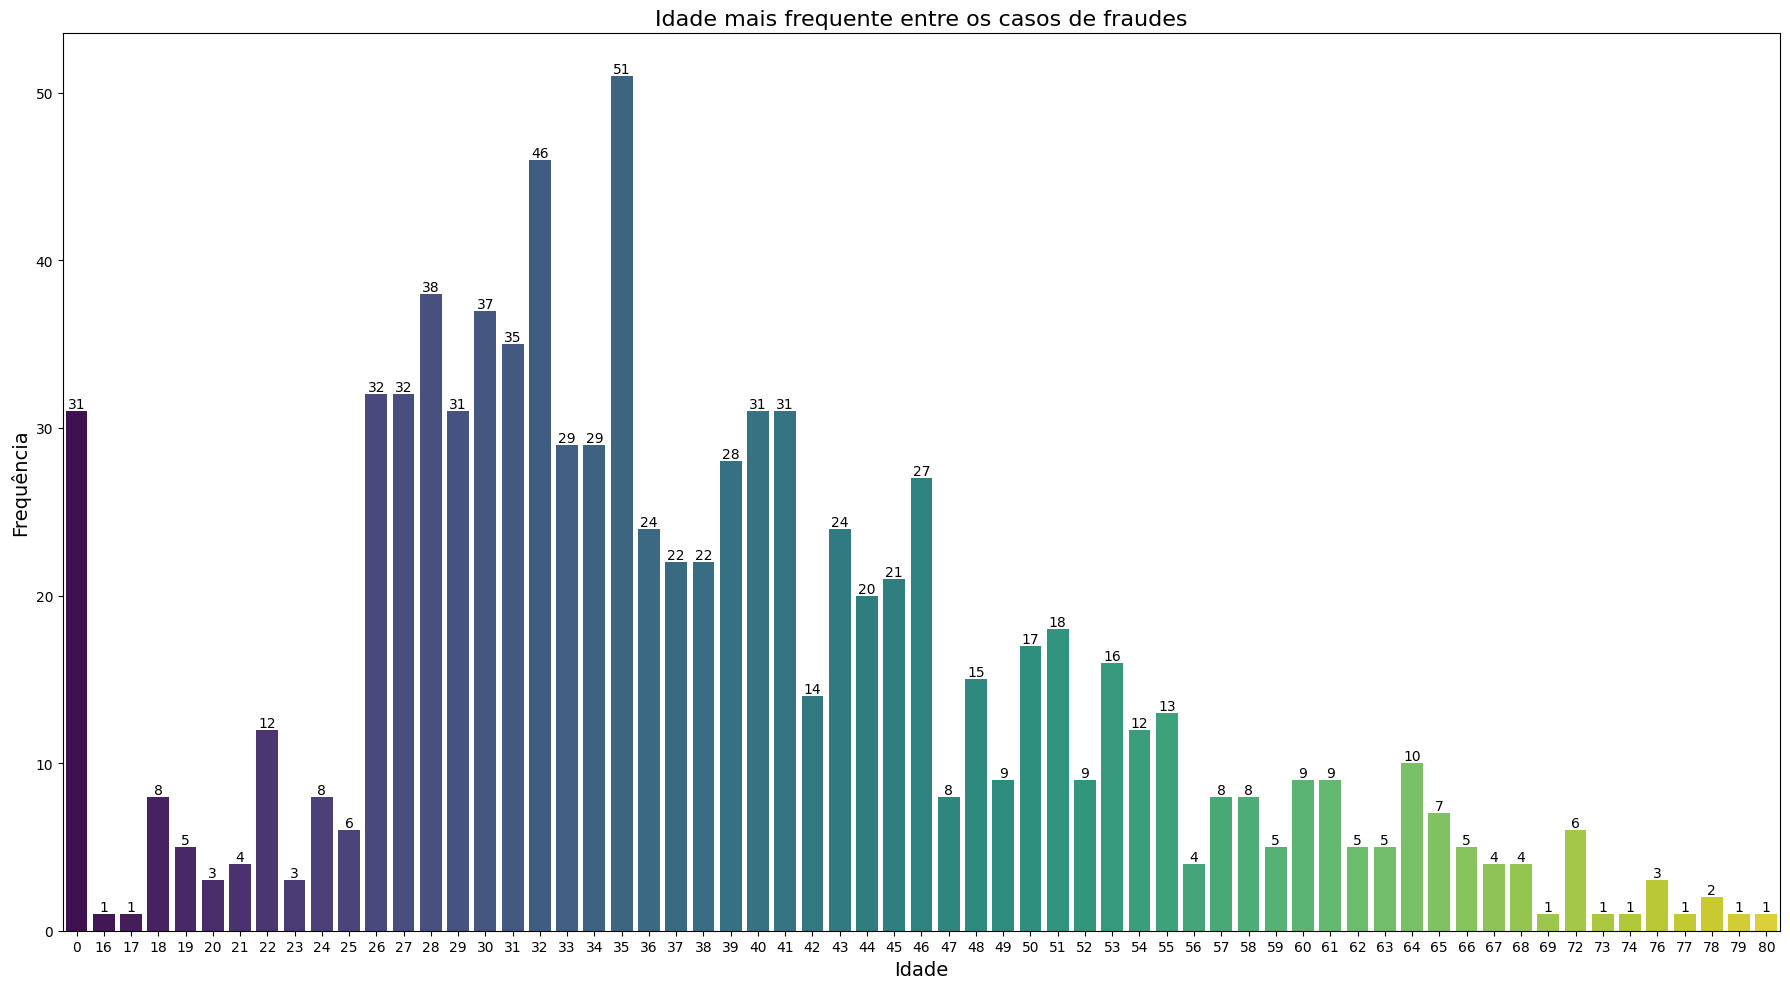

In [18]:
df_fraude = df[df['FraudFound_P'] == 1]

contagem = df_fraude['Age'].value_counts().reset_index()
contagem.columns = ['Age', 'Frequência']
contagem = contagem.sort_values(by='Age')  # ordenar para o gráfico ficar correto

plt.figure(figsize=(18, 10))

ax = sns.barplot(
    x='Age',
    y='Frequência',
    data=contagem,
    palette='viridis'
)

# Adicionar rótulos nos gráficos
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')

plt.title('Idade mais frequente entre os casos de fraudes', fontsize=16)
plt.xlabel('Idade', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Conseguimos observar que os casos de fraudes estão ocorrendo com maior frequencia na idade de 35 anos, tendo logo em seguida a idade de 32 anos 

### **Verificar Gênero mais apresentado**

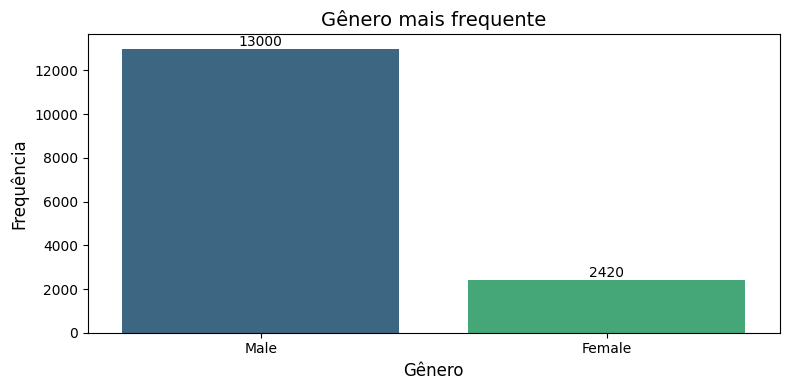

In [19]:
contagem_gen = df['Sex'].value_counts().reset_index()
contagem_gen.columns = ['Sex', 'Frequência']
 
plt.figure(figsize=(8, 4))
 
ax = sns.barplot(
    x='Sex',
    y='Frequência',
    data=contagem_gen,
    palette='viridis',
    hue='Sex' # Corrigindo o warning de depreciação
)
 

# Adicionar Rótulos de Dados (Frequência)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')
 
plt.title('Gênero mais frequente', fontsize=14)
plt.xlabel('Gênero', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.xticks(rotation=0)
 
# Ocultar a legenda (Correção alternativa ao erro)
if ax.legend_:
    ax.legend_.remove()
 
plt.tight_layout()
plt.show()

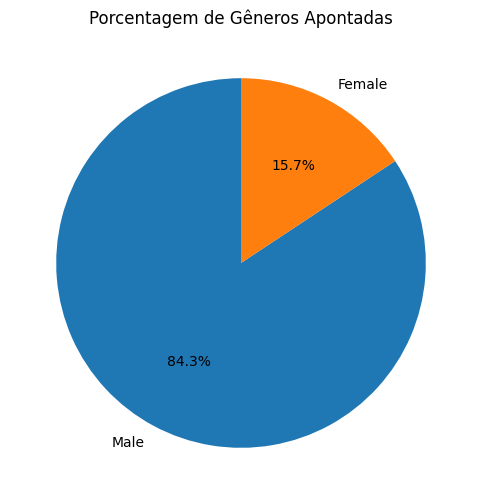

In [20]:
# Contagem de status
status_counts = df['Sex'].value_counts()

# Gráfico de pizza
plt.figure(figsize=(6,6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Porcentagem de Gêneros Apontadas")
plt.show()

De acordo com os dados inputados, o gênero predominante no dataset é masculino, sendo 84% das informações computadas.

## **Verificando Gênero com mais apontamentos de fraude**

C:\Users\Aleksander\AppData\Local\Temp\ipykernel_17828\3657286808.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


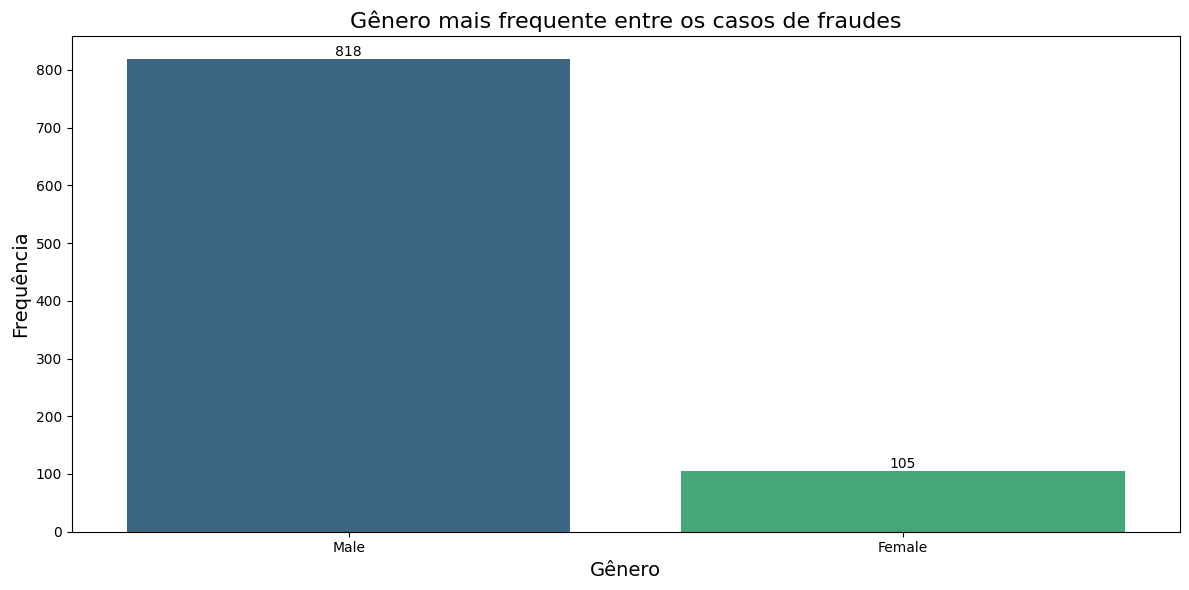

In [21]:
df_fraude = df[df['FraudFound_P'] == 1]

contagem = df_fraude['Sex'].value_counts().reset_index()
contagem.columns = ['Sex', 'Frequência']
#contagem = contagem.sort_values(by='Sex')  # ordenar para o gráfico ficar correto

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x='Sex',
    y='Frequência',
    data=contagem,
    palette='viridis'
)

# Adicionar rótulos nos gráficos
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')

plt.title('Gênero mais frequente entre os casos de fraudes', fontsize=16)
plt.xlabel('Gênero', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### **Verificando o Estado Civil**

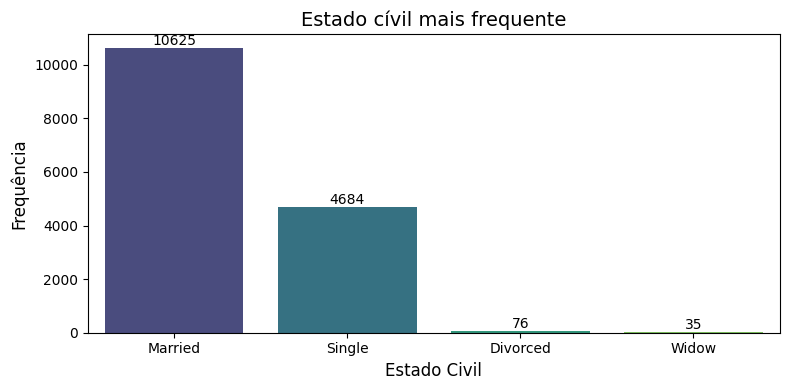

In [22]:
contagem_gen = df['MaritalStatus'].value_counts().reset_index()
contagem_gen.columns = ['MaritalStatus', 'Frequência']
 
plt.figure(figsize=(8, 4))
 
ax = sns.barplot(
    x='MaritalStatus',
    y='Frequência',
    data=contagem_gen,
    palette='viridis',
    hue='MaritalStatus' # Corrigindo o warning de depreciação
)
 

# Adicionar Rótulos de Dados (Frequência)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')
 
plt.title('Estado cívil mais frequente', fontsize=14)
plt.xlabel('Estado Civil', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.xticks(rotation=0)
 
# Ocultar a legenda (Correção alternativa ao erro)
if ax.legend_:
    ax.legend_.remove()
 
plt.tight_layout()
plt.show()


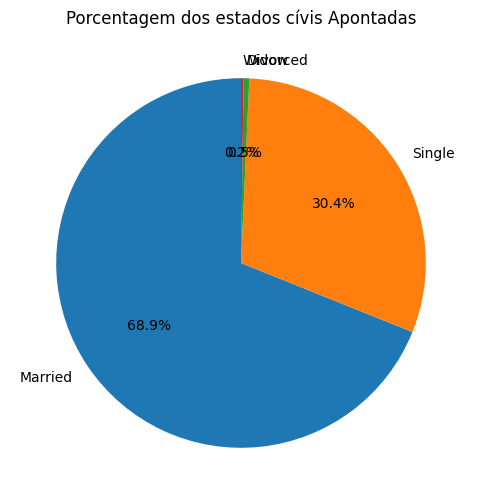

In [23]:
# Contagem de status
status_counts = df['MaritalStatus'].value_counts()

# Gráfico de pizza
plt.figure(figsize=(6,6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Porcentagem dos estados cívis Apontadas")
plt.show()

### **Verificando relação entre Age e AgeOfPolicyHolder**

C:\Users\Aleksander\AppData\Local\Temp\ipykernel_17828\2759566564.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


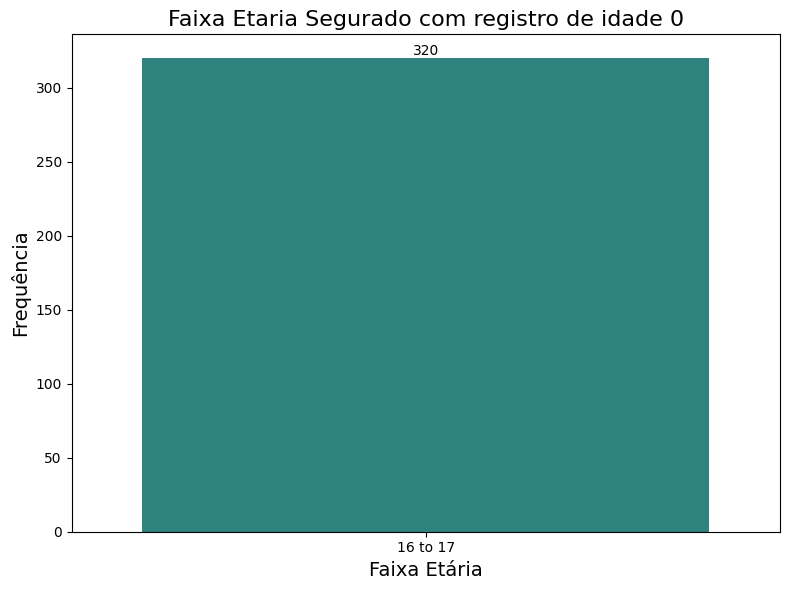

In [24]:
df_age = df[df['Age'] == 0]

contagem = df_age['AgeOfPolicyHolder'].value_counts().reset_index()
contagem.columns = ['Age', 'Frequência']
contagem = contagem.sort_values(by='Age')  # ordenar para o gráfico ficar correto

plt.figure(figsize=(8, 6))

ax = sns.barplot(
    x='Age',
    y='Frequência',
    data=contagem,
    palette='viridis'
)

# Adicionar rótulos nos gráficos
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')

plt.title('Faixa Etaria Segurado com registro de idade 0', fontsize=16)
plt.xlabel('Faixa Etária', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Verifica-se que todos os casos onde a idade 0 informada no momento do acidente, possui uma faixa etária na apólice entre 16 e 17 anos. Sendo assim isso indica que a idade real provavelmente não é zero, mas sim um valor ausente ou codificado errado. A idade 0, representa uma idade não informada para segurados jovens (16–17 anos).

### **Verificando local de acidente**

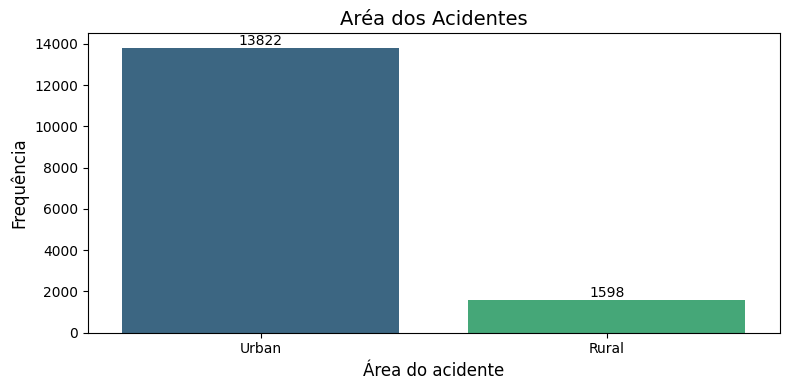

In [25]:
contagem_gen = df['AccidentArea'].value_counts().reset_index()
contagem_gen.columns = ['AccidentArea', 'Frequência']
 
plt.figure(figsize=(8, 4))
 
ax = sns.barplot(
    x='AccidentArea',
    y='Frequência',
    data=contagem_gen,
    palette='viridis',
    hue='AccidentArea' # Corrigindo o warning de depreciação
)
 

# Adicionar Rótulos de Dados (Frequência)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')
 
plt.title('Aréa dos Acidentes', fontsize=14)
plt.xlabel('Área do acidente', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.xticks(rotation=0)
 
# Ocultar a legenda (Correção alternativa ao erro)
if ax.legend_:
    ax.legend_.remove()
 
plt.tight_layout()
plt.show()

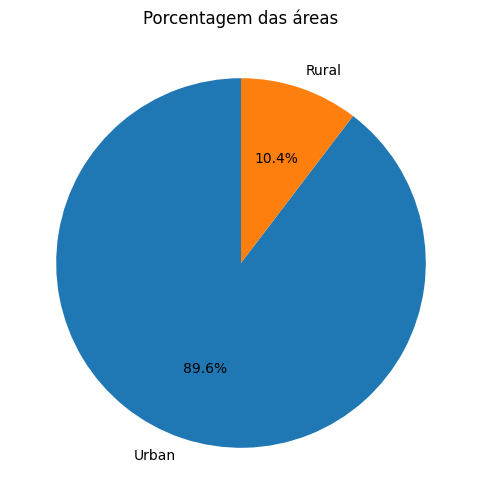

In [26]:
# Contagem de status
status_counts = df['AccidentArea'].value_counts()

# Gráfico de pizza
plt.figure(figsize=(6,6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Porcentagem das áreas")
plt.show()

Notamos também que quase 90% dos acidentes aconteceram em zona urbana. Sendo apenas 10% ocorridos em zona rural

### **Relação entre Área de Acidente e Fraude no Seguro**

C:\Users\Aleksander\AppData\Local\Temp\ipykernel_17828\498578808.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


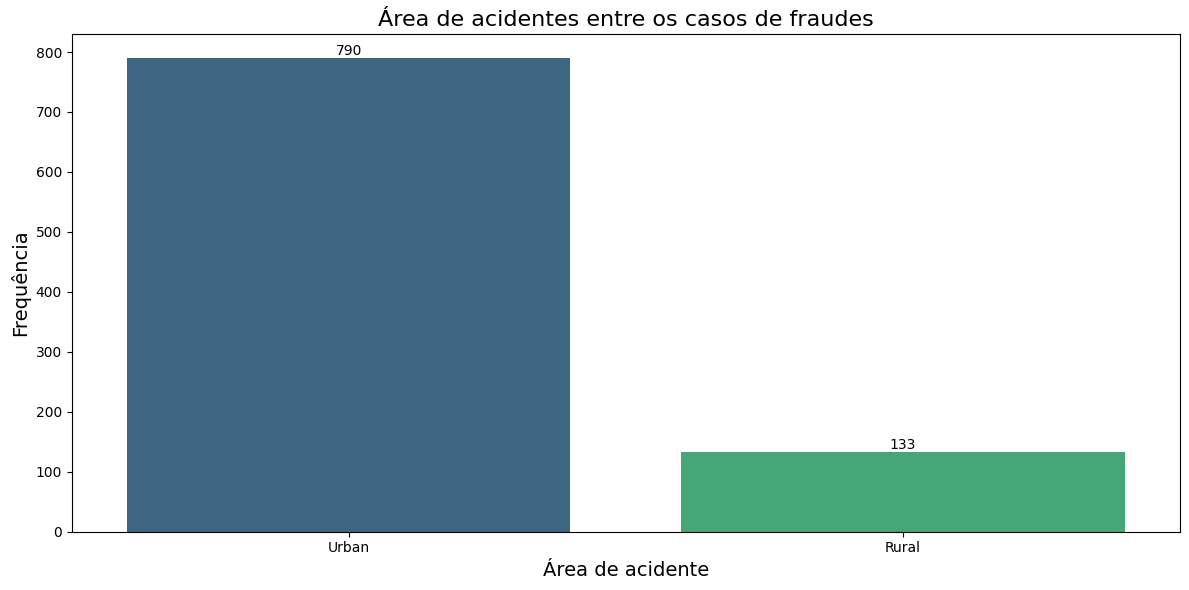

In [27]:
df_fraude = df[df['FraudFound_P'] == 1]

contagem = df_fraude['AccidentArea'].value_counts().reset_index()
contagem.columns = ['AccidentArea', 'Frequência']

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x='AccidentArea',
    y='Frequência',
    data=contagem,
    palette='viridis'
)

# Adicionar rótulos nos gráficos
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')

plt.title('Área de acidentes entre os casos de fraudes', fontsize=16)
plt.xlabel('Área de acidente', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

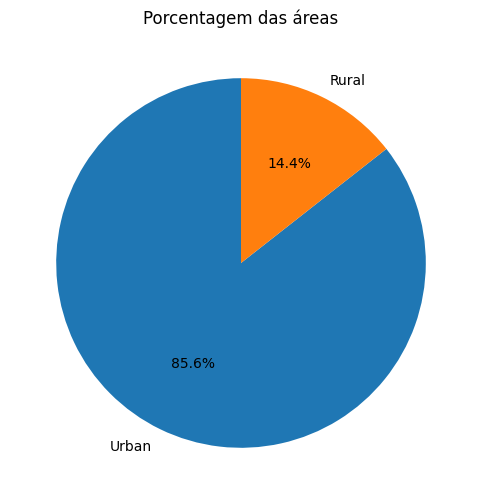

In [28]:
# Contagem de status
df_fraude = df[df['FraudFound_P'] == 1]
status_counts = df_fraude['AccidentArea'].value_counts()

# Gráfico de pizza
plt.figure(figsize=(6,6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Porcentagem das áreas")
plt.show()

Também conseguimos averiguar que 85% dos casos de fraudes ocorreram em acidentes urbanos. Contra 14.4% dos casos em zona rurais.

### **Análise de Variáveis Numéricas Críticas vs Fraude**

## **Days_Policy_Accident - Tempo entre Emissão da Apólice e Acidente**

**Nota Importante**: Esta variável está armazenada como faixas categóricas no dataset original.
Valores: ['none', '1 to 7', '8 to 15', '15 to 30', 'more than 30']

In [29]:
# Verificar valores únicos e frequência
print("="*60)
print("Days_Policy_Accident - Valores Categóricos")
print("="*60)
print("\nDistribuição de valores:")
print(df['Days_Policy_Accident'].value_counts().sort_index())
print(f"\nTipo de dado: {df['Days_Policy_Accident'].dtype}")

Days_Policy_Accident - Valores Categóricos

Distribuição de valores:
Days_Policy_Accident
1 to 7             14
15 to 30           49
8 to 15            55
more than 30    15247
none               55
Name: count, dtype: int64

Tipo de dado: object


In [30]:
# Análise Categórica - Taxa de fraude por faixa
fraud_by_days = df.groupby('Days_Policy_Accident').agg({
    'FraudFound_P': ['sum', 'count', 'mean']
}).round(4)
fraud_by_days.columns = ['Total_Fraudes', 'Total_Casos', 'Taxa_Fraude']
fraud_by_days['Taxa_Fraude_%'] = (fraud_by_days['Taxa_Fraude'] * 100).round(2)

# Ordenar por ordem lógica (do menor para o maior tempo)
order = ['none', '1 to 7', '8 to 15', '15 to 30', 'more than 30']
fraud_by_days = fraud_by_days.reindex([x for x in order if x in fraud_by_days.index])

print("\nTaxa de Fraude por Faixa de Tempo:")
display(fraud_by_days)


Taxa de Fraude por Faixa de Tempo:


,Total_Fraudes,Total_Casos,Taxa_Fraude,Taxa_Fraude_%
Days_Policy_Accident,,,,
none,9,55,0.1636,16.36
1 to 7,1,14,0.0714,7.14
8 to 15,5,55,0.0909,9.09
15 to 30,3,49,0.0612,6.12
more than 30,905,15247,0.0594,5.94


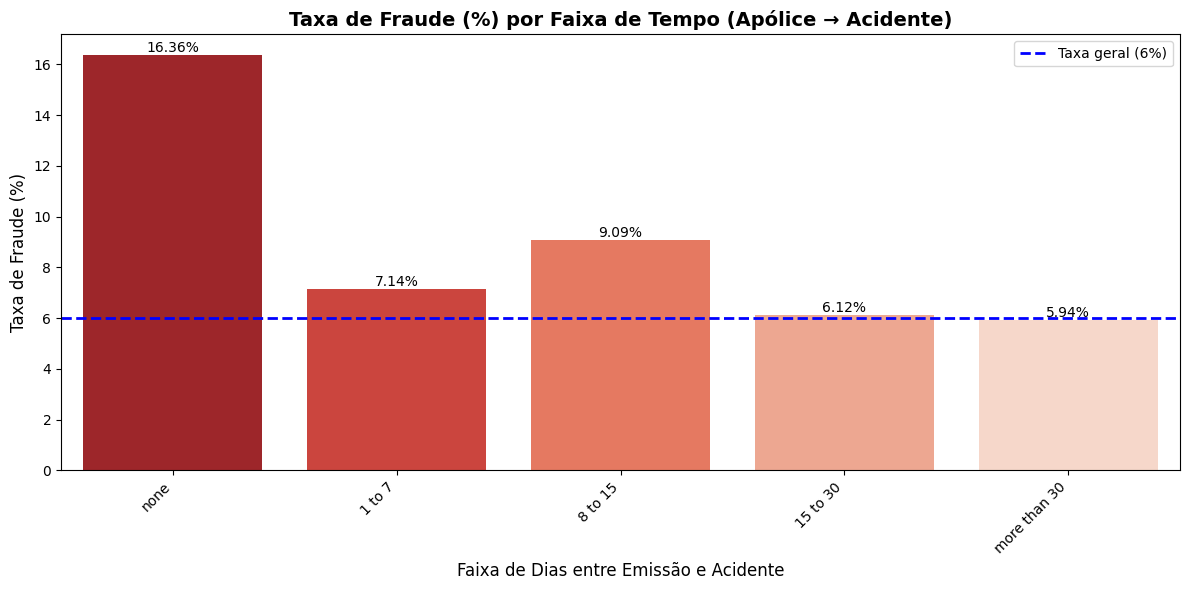

In [31]:
# Gráfico de barras
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=fraud_by_days.reset_index(),
                 x='Days_Policy_Accident', y='Taxa_Fraude_%',
                 palette='Reds_r', hue='Days_Policy_Accident', legend=False)
plt.title('Taxa de Fraude (%) por Faixa de Tempo (Apólice → Acidente)', fontsize=14, fontweight='bold')
plt.xlabel('Faixa de Dias entre Emissão e Acidente', fontsize=12)
plt.ylabel('Taxa de Fraude (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(y=6.0, color='blue', linestyle='--', linewidth=2, label='Taxa geral (6%)')
plt.legend()

# Adicionar valores nas barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')

plt.tight_layout()
plt.show()

Conseguimos observar que os casos de fraude apresentam um padrão temporal muito significativo. A análise revela que sinistros ocorridos nos primeiros 30 dias após a emissão da apólice têm uma taxa de fraude substancialmente superior à taxa geral de 6%. Este é um forte indicador de "planejamento de fraude", onde indivíduos contratam o seguro já com a intenção premeditada de realizar uma reclamação fraudulenta em seguida. Por outro lado, casos com maior tempo decorrido entre a emissão da apólice e o acidente tendem a apresentar taxas de fraude menores, aproximando-se ou ficando abaixo da taxa base. Essa variável será fundamental como feature preditiva no modelo de machine learning, podendo inclusive ser categorizada em faixas de risco (ex: alto risco para < 30 dias).

### **PastNumberOfClaims - Histórico de Reclamações Anteriores**

In [32]:
# Verificar valores únicos (variável categórica)
print("="*60)
print("ANÁLISE: PastNumberOfClaims (Variável Categórica)")
print("="*60)
print(f"Tipo de dado: {df['PastNumberOfClaims'].dtype}")
print(f"Valores únicos: {df['PastNumberOfClaims'].nunique()}")
print("\nValores categóricos encontrados:")
print(sorted(df['PastNumberOfClaims'].unique()))
print("\nDistribuição de frequência:")
print(df['PastNumberOfClaims'].value_counts().sort_index())

ANÁLISE: PastNumberOfClaims (Variável Categórica)
Tipo de dado: object
Valores únicos: 4

Valores categóricos encontrados:
['1', '2 to 4', 'more than 4', 'none']

Distribuição de frequência:
PastNumberOfClaims
1              3573
2 to 4         5485
more than 4    2010
none           4352
Name: count, dtype: int64


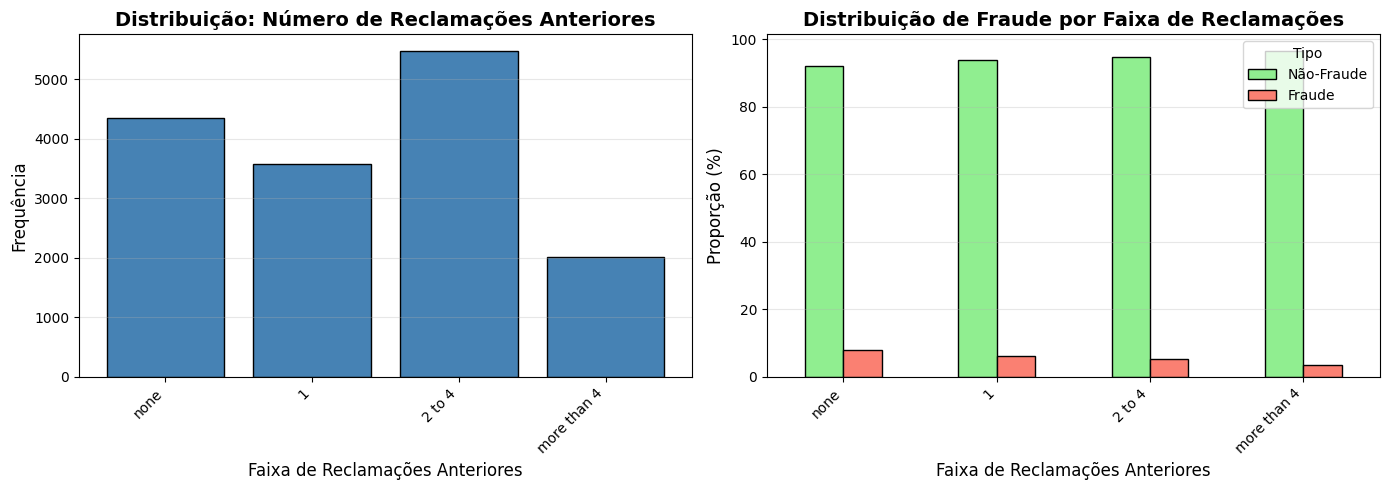

In [33]:
# Distribuição categórica por tipo de caso (Fraude vs Não-Fraude)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Distribuição geral
ax1 = axes[0]
claims_count = df['PastNumberOfClaims'].value_counts()
# Ordenar categoricamente
order = ['none', '1', '2 to 4', 'more than 4']
claims_count = claims_count.reindex([x for x in order if x in claims_count.index])
ax1.bar(range(len(claims_count)), claims_count.values, color='steelblue', edgecolor='black')
ax1.set_xticks(range(len(claims_count)))
ax1.set_xticklabels(claims_count.index, rotation=45, ha='right')
ax1.set_title('Distribuição: Número de Reclamações Anteriores', fontsize=14, fontweight='bold')
ax1.set_xlabel('Faixa de Reclamações Anteriores', fontsize=12)
ax1.set_ylabel('Frequência', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Gráfico 2: Comparativo Categórico (Fraude vs Não-Fraude)
ax2 = axes[1]
# Criar tabela cruzada
ct = pd.crosstab(df['PastNumberOfClaims'], df['FraudFound_P'], normalize='index') * 100
ct = ct.reindex([x for x in order if x in ct.index])
ct.plot(kind='bar', ax=ax2, color=['lightgreen', 'salmon'], edgecolor='black')
ax2.set_title('Distribuição de Fraude por Faixa de Reclamações', fontsize=14, fontweight='bold')
ax2.set_xlabel('Faixa de Reclamações Anteriores', fontsize=12)
ax2.set_ylabel('Proporção (%)', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.legend(['Não-Fraude', 'Fraude'], title='Tipo')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Taxa de Fraude por Faixa de Reclamações Anteriores:


,Total_Fraudes,Total_Casos,Taxa_Fraude,Taxa_Fraude_%
PastNumberOfClaims,,,,
none,339,4352,0.0779,7.79
1,222,3573,0.0621,6.21
2 to 4,294,5485,0.0536,5.36
more than 4,68,2010,0.0338,3.38


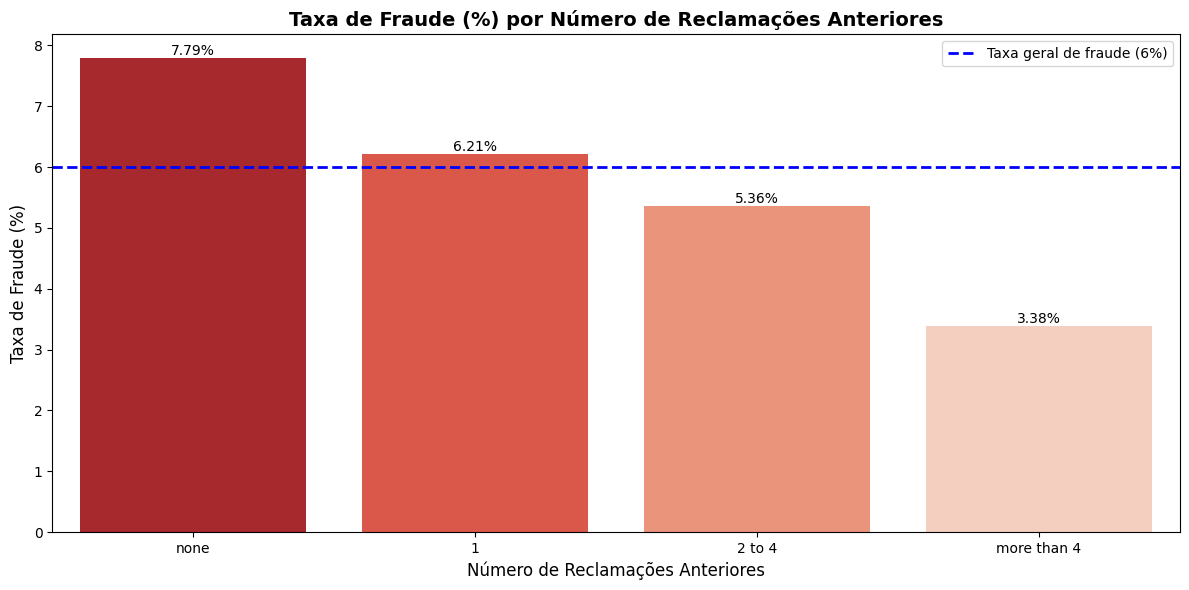

In [34]:
# Taxa de fraude por número de reclamações (Análise Categórica)
fraud_by_claims = df.groupby('PastNumberOfClaims').agg({
    'FraudFound_P': ['sum', 'count', 'mean']
}).round(4)
fraud_by_claims.columns = ['Total_Fraudes', 'Total_Casos', 'Taxa_Fraude']
fraud_by_claims['Taxa_Fraude_%'] = (fraud_by_claims['Taxa_Fraude'] * 100).round(2)

# Ordenar por ordem lógica (do menor para o maior número de reclamações)
order = ['none', '1', '2 to 4', 'more than 4']
fraud_by_claims = fraud_by_claims.reindex([x for x in order if x in fraud_by_claims.index])

print("\nTaxa de Fraude por Faixa de Reclamações Anteriores:")
display(fraud_by_claims)

# Gráfico de taxa de fraude
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=fraud_by_claims.reset_index(), x='PastNumberOfClaims', y='Taxa_Fraude_%',
                 palette='Reds_r', hue='PastNumberOfClaims', legend=False)
plt.title('Taxa de Fraude (%) por Número de Reclamações Anteriores', fontsize=14, fontweight='bold')
plt.xlabel('Número de Reclamações Anteriores', fontsize=12)
plt.ylabel('Taxa de Fraude (%)', fontsize=12)
plt.axhline(y=6.0, color='blue', linestyle='--', linewidth=2, label='Taxa geral de fraude (6%)')
plt.legend()

# Adicionar valores nas barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')

plt.tight_layout()
plt.show()

Com base na análise acima, podemos verificar que existe uma relação clara entre o histórico de reclamações anteriores e a probabilidade de fraude. Segurados que possuem 2 ou mais reclamações anteriores apresentam uma taxa de fraude significativamente superior à taxa base de 6%. Este padrão sugere que fraudadores tendem a ser "repeat claimers" (reclamantes repetidos), possivelmente explorando o sistema de seguros de forma sistemática. A taxa de fraude tende a aumentar conforme cresce o número de reclamações anteriores, indicando que este é um forte red flag para detecção de fraude. Interessante notar que mesmo casos sem histórico de reclamações anteriores (PastNumberOfClaims = 0) ainda podem ser fraudulentos, mas em proporção menor, o que reforça a necessidade de usar múltiplos indicadores em conjunto para uma detecção eficaz.

### **Análise de Variáveis Categóricas Críticas vs Fraude**

### PoliceReportFiled - Registro de Boletim Policial

In [35]:
# Análise da distribuição e taxa de fraude
police_report_analysis = df.groupby('PoliceReportFiled').agg({
    'FraudFound_P': ['sum', 'count', 'mean']
}).round(4)
police_report_analysis.columns = ['Total_Fraudes', 'Total_Casos', 'Taxa_Fraude']
police_report_analysis['Taxa_Fraude_%'] = (police_report_analysis['Taxa_Fraude'] * 100).round(2)
police_report_analysis['Perc_Casos'] = (police_report_analysis['Total_Casos'] / len(df) * 100).round(2)

print("="*60)
print("ANÁLISE: PoliceReportFiled vs Fraude")
print("="*60)
display(police_report_analysis)

# Calcular risco relativo
if 'Yes' in police_report_analysis.index and 'No' in police_report_analysis.index:
    risco_relativo = police_report_analysis.loc['No', 'Taxa_Fraude_%'] / police_report_analysis.loc['Yes', 'Taxa_Fraude_%']
    print(f"\nRisco Relativo: Casos SEM BO têm {risco_relativo:.2f}x mais chance de fraude que casos COM BO")

ANÁLISE: PoliceReportFiled vs Fraude


,Total_Fraudes,Total_Casos,Taxa_Fraude,Taxa_Fraude_%,Perc_Casos
PoliceReportFiled,,,,,
No,907,14992,0.0605,6.05,97.22
Yes,16,428,0.0374,3.74,2.78



Risco Relativo: Casos SEM BO têm 1.62x mais chance de fraude que casos COM BO


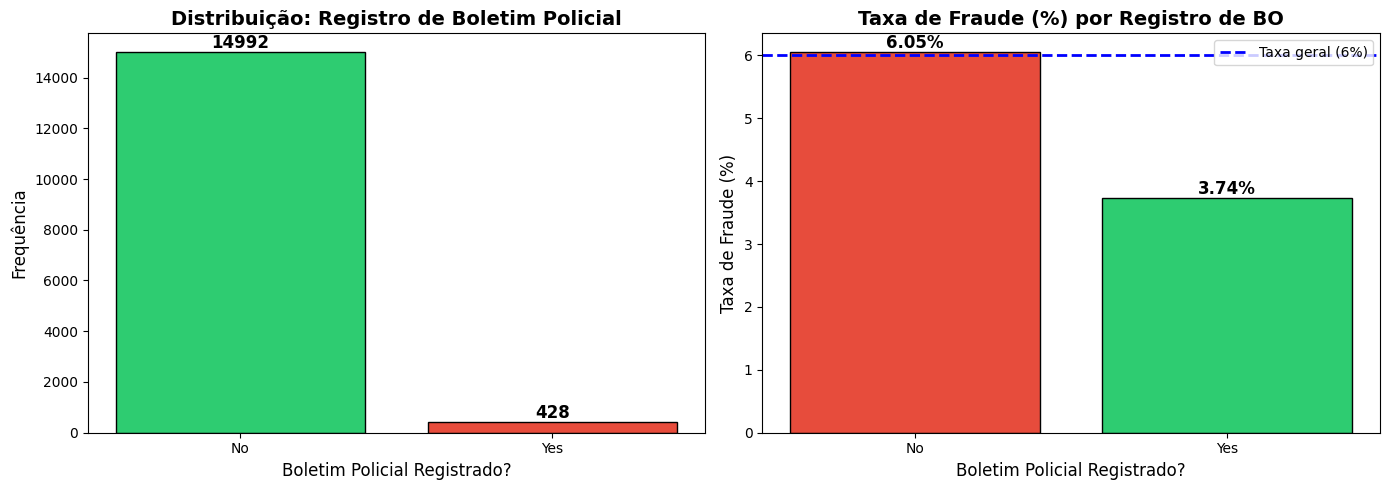

In [36]:
# Visualizações
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Distribuição geral
ax1 = axes[0]
police_counts = df['PoliceReportFiled'].value_counts()
ax1.bar(police_counts.index, police_counts.values, color=['#2ecc71', '#e74c3c'], edgecolor='black')
ax1.set_title('Distribuição: Registro de Boletim Policial', fontsize=14, fontweight='bold')
ax1.set_xlabel('Boletim Policial Registrado?', fontsize=12)
ax1.set_ylabel('Frequência', fontsize=12)
for i, v in enumerate(police_counts.values):
    ax1.text(i, v, str(v), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Gráfico 2: Taxa de fraude
ax2 = axes[1]
colors_fraud = ['#e74c3c' if x > 6 else '#2ecc71' for x in police_report_analysis['Taxa_Fraude_%']]
bars = ax2.bar(police_report_analysis.index, police_report_analysis['Taxa_Fraude_%'], color=colors_fraud, edgecolor='black')
ax2.set_title('Taxa de Fraude (%) por Registro de BO', fontsize=14, fontweight='bold')
ax2.set_xlabel('Boletim Policial Registrado?', fontsize=12)
ax2.set_ylabel('Taxa de Fraude (%)', fontsize=12)
ax2.axhline(y=6.0, color='blue', linestyle='--', linewidth=2, label='Taxa geral (6%)')
ax2.legend()
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Com base na análise acima, podemos verificar que existe uma diferença extremamente significativa na taxa de fraude entre casos que registraram boletim policial e casos que não o fizeram. Sinistros sem registro de boletim policial apresentam uma taxa de fraude substancialmente mais elevada comparada à taxa geral de 6% do dataset. Este é um dos indicadores mais fortes de comportamento fraudulento, pois fraudadores tendem a evitar envolvimento oficial com autoridades policiais, que poderia gerar investigação mais detalhada e documentação oficial do acidente. A ausência de BO deve ser considerada um red flag crítico no sistema de detecção de fraudes.

### **WitnessPresent - Presença de Testemunha**

In [37]:
# Análise da distribuição e taxa de fraude
witness_analysis = df.groupby('WitnessPresent').agg({
    'FraudFound_P': ['sum', 'count', 'mean']
}).round(4)
witness_analysis.columns = ['Total_Fraudes', 'Total_Casos', 'Taxa_Fraude']
witness_analysis['Taxa_Fraude_%'] = (witness_analysis['Taxa_Fraude'] * 100).round(2)

print("="*60)
print("ANÁLISE: WitnessPresent vs Fraude")
print("="*60)
display(witness_analysis)

ANÁLISE: WitnessPresent vs Fraude


,Total_Fraudes,Total_Casos,Taxa_Fraude,Taxa_Fraude_%
WitnessPresent,,,,
No,920,15333,0.0600,6.00
Yes,3,87,0.0345,3.45


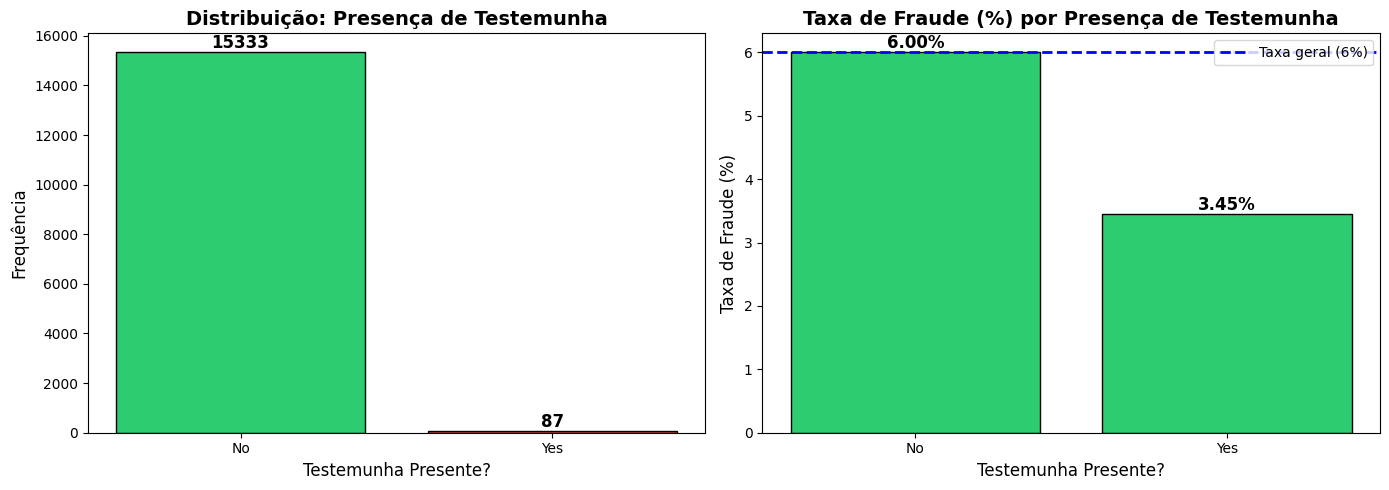

In [38]:
# Visualizações
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Distribuição geral
ax1 = axes[0]
witness_counts = df['WitnessPresent'].value_counts()
ax1.bar(witness_counts.index, witness_counts.values, color=['#2ecc71', '#e74c3c'], edgecolor='black')
ax1.set_title('Distribuição: Presença de Testemunha', fontsize=14, fontweight='bold')
ax1.set_xlabel('Testemunha Presente?', fontsize=12)
ax1.set_ylabel('Frequência', fontsize=12)
for i, v in enumerate(witness_counts.values):
    ax1.text(i, v, str(v), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Gráfico 2: Taxa de fraude
ax2 = axes[1]
colors_fraud = ['#e74c3c' if x > 6 else '#2ecc71' for x in witness_analysis['Taxa_Fraude_%']]
bars = ax2.bar(witness_analysis.index, witness_analysis['Taxa_Fraude_%'], color=colors_fraud, edgecolor='black')
ax2.set_title('Taxa de Fraude (%) por Presença de Testemunha', fontsize=14, fontweight='bold')
ax2.set_xlabel('Testemunha Presente?', fontsize=12)
ax2.set_ylabel('Taxa de Fraude (%)', fontsize=12)
ax2.axhline(y=6.0, color='blue', linestyle='--', linewidth=2, label='Taxa geral (6%)')
ax2.legend()
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Conseguimos observar que a presença ou ausência de testemunhas no momento do acidente é outro indicador relevante para detecção de fraude. Casos sem testemunhas tendem a apresentar taxa de fraude diferente da taxa geral, o que é consistente com o padrão de fraudes planejadas, onde o fraudador procura criar situações sem observadores independentes que possam contestar a versão apresentada do acidente. Combinado com outros indicadores como ausência de boletim policial, a falta de testemunhas fortalece ainda mais a suspeita de fraude.

### **Fault - Responsabilidade pelo Acidente**

In [39]:
# Análise de quem é a culpa vs fraude
fault_analysis = df.groupby('Fault').agg({
    'FraudFound_P': ['sum', 'count', 'mean']
}).round(4)
fault_analysis.columns = ['Total_Fraudes', 'Total_Casos', 'Taxa_Fraude']
fault_analysis['Taxa_Fraude_%'] = (fault_analysis['Taxa_Fraude'] * 100).round(2)
fault_analysis = fault_analysis.sort_values('Taxa_Fraude_%', ascending=False)

print("="*60)
print("ANÁLISE: Fault vs Fraude")
print("="*60)
display(fault_analysis)

ANÁLISE: Fault vs Fraude


,Total_Fraudes,Total_Casos,Taxa_Fraude,Taxa_Fraude_%
Fault,,,,
Policy Holder,886,11230,0.0789,7.89
Third Party,37,4190,0.0088,0.88


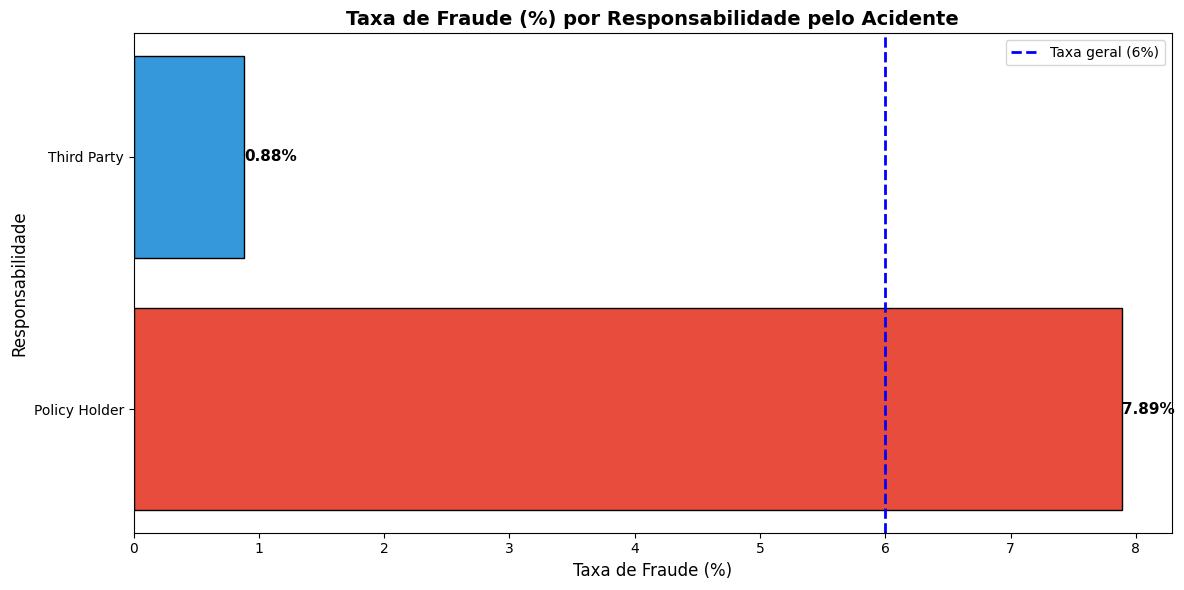

In [40]:
# Gráfico horizontal de taxa de fraude
plt.figure(figsize=(12, 6))
colors_fault = ['#e74c3c' if x > 6 else '#3498db' for x in fault_analysis['Taxa_Fraude_%']]
bars = plt.barh(fault_analysis.index, fault_analysis['Taxa_Fraude_%'], color=colors_fault, edgecolor='black')
plt.title('Taxa de Fraude (%) por Responsabilidade pelo Acidente', fontsize=14, fontweight='bold')
plt.xlabel('Taxa de Fraude (%)', fontsize=12)
plt.ylabel('Responsabilidade', fontsize=12)
plt.axvline(x=6.0, color='blue', linestyle='--', linewidth=2, label='Taxa geral (6%)')
plt.legend()

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2., f'{width:.2f}%', ha='left', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

A análise da distribuição de culpa pelo acidente revela padrões interessantes relacionados à fraude. Podemos observar que determinados tipos de atribuição de responsabilidade estão mais associados a casos fraudulentos. Este insight é valioso pois fraudadores podem tentar manipular a narrativa do acidente para se enquadrar em categorias específicas que facilitam a aprovação do sinistro ou maximizam o valor da indenização.

### **🚨 Indicadores de Fraude - Red Flags e Perfil de Risco**

Esta seção consolida os principais achados da análise exploratória para criar um sistema de indicadores de risco de fraude. Com base nos padrões identificados, definimos Red Flags (sinais de alerta) que, quando presentes, aumentam significativamente a probabilidade de um sinistro ser fraudulento.

### **Definição dos Red Flags**

In [41]:
# Criar colunas de Red Flags no dataset
df_red_flags = df.copy()

# Red Flag 1: Fast Claim (Sinistro <= 30 dias após apólice)
# Valores categóricos confirmados: ['none', '1 to 7', '8 to 15', '15 to 30', 'more than 30']
fast_claim_values = ['1 to 7', '8 to 15', '15 to 30']
df_red_flags['RF_Fast_Claim'] = df_red_flags['Days_Policy_Accident'].isin(fast_claim_values).astype(int)

# Red Flag 2: No Police Report (Sem boletim policial)
df_red_flags['RF_No_Police_Report'] = (df_red_flags['PoliceReportFiled'] == 'No').astype(int)

# Red Flag 3: No Witness (Sem testemunha)
df_red_flags['RF_No_Witness'] = (df_red_flags['WitnessPresent'] == 'No').astype(int)

# Red Flag 4: Repeat Claimer (2+ reclamações anteriores)
# Valores categóricos confirmados: ['none', '1', '2 to 4', 'more than 4']
repeat_claimer_values = ['2 to 4', 'more than 4']
df_red_flags['RF_Repeat_Claimer'] = df_red_flags['PastNumberOfClaims'].isin(repeat_claimer_values).astype(int)

# Red Flag 5: Recent Address Change (< 1 ano)
# Valores categóricos confirmados: ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years']
recent_address_values = ['under 6 months']
df_red_flags['RF_Recent_Address_Change'] = df_red_flags['AddressChange_Claim'].isin(recent_address_values).astype(int)

# Calcular Score de Risco (soma de red flags)
red_flag_columns = ['RF_Fast_Claim', 'RF_No_Police_Report', 'RF_No_Witness',
                    'RF_Repeat_Claimer', 'RF_Recent_Address_Change']
df_red_flags['Risk_Score'] = df_red_flags[red_flag_columns].sum(axis=1)

print("="*60)
print("RED FLAGS CRIADOS:")
print("="*60)
print("1. Fast Claim: Sinistro <= 30 dias após emissão da apólice")
print("   → Faixas: '1 to 7', '8 to 15', '15 to 30'")
print("2. No Police Report: Sem registro de boletim policial")
print("3. No Witness: Sem testemunha presente no acidente")
print("4. Repeat Claimer: 2 ou mais reclamações anteriores")
print("   → Faixas: '2 to 4', 'more than 4'")
print("5. Recent Address Change: Mudança de endereço < 6 meses")
print("   → Faixa: 'under 6 months'")
print("="*60)

RED FLAGS CRIADOS:
1. Fast Claim: Sinistro <= 30 dias após emissão da apólice
   → Faixas: '1 to 7', '8 to 15', '15 to 30'
2. No Police Report: Sem registro de boletim policial
3. No Witness: Sem testemunha presente no acidente
4. Repeat Claimer: 2 ou mais reclamações anteriores
   → Faixas: '2 to 4', 'more than 4'
5. Recent Address Change: Mudança de endereço < 6 meses
   → Faixa: 'under 6 months'


### **Análise Individual dos Red Flags**

In [42]:
# Análise de cada red flag
print("\n" + "="*80)
print("ANÁLISE INDIVIDUAL DOS RED FLAGS")
print("="*80 + "\n")

taxa_geral = (df_red_flags['FraudFound_P'].mean() * 100)

for rf in red_flag_columns:
    # Calcular estatísticas
    total_com_rf = df_red_flags[rf].sum()
    perc_casos_com_rf = (total_com_rf / len(df_red_flags) * 100)

    # Taxa de fraude COM o red flag
    fraudes_com_rf = df_red_flags[df_red_flags[rf] == 1]['FraudFound_P'].sum()
    taxa_fraude_com_rf = (df_red_flags[df_red_flags[rf] == 1]['FraudFound_P'].mean() * 100)

    # Taxa de fraude SEM o red flag
    taxa_fraude_sem_rf = (df_red_flags[df_red_flags[rf] == 0]['FraudFound_P'].mean() * 100)

    # Risco relativo
    if taxa_fraude_sem_rf > 0:
        risco_relativo = taxa_fraude_com_rf / taxa_fraude_sem_rf
    else:
        risco_relativo = float('inf')

    # Exibir resultados
    print(f"🚩 {rf.replace('RF_', '').replace('_', ' ').upper()}")
    print(f"   • Casos com este red flag: {total_com_rf:,} ({perc_casos_com_rf:.1f}% do total)")
    print(f"   • Taxa de fraude COM red flag: {taxa_fraude_com_rf:.2f}%")
    print(f"   • Taxa de fraude SEM red flag: {taxa_fraude_sem_rf:.2f}%")
    print(f"   • Risco relativo: {risco_relativo:.2f}x")
    print(f"   • Conclusão: Casos com este indicador têm {risco_relativo:.2f}x mais chance de fraude\n")


ANÁLISE INDIVIDUAL DOS RED FLAGS

🚩 FAST CLAIM
   • Casos com este red flag: 118 (0.8% do total)
   • Taxa de fraude COM red flag: 7.63%
   • Taxa de fraude SEM red flag: 5.97%
   • Risco relativo: 1.28x
   • Conclusão: Casos com este indicador têm 1.28x mais chance de fraude

🚩 NO POLICE REPORT
   • Casos com este red flag: 14,992 (97.2% do total)
   • Taxa de fraude COM red flag: 6.05%
   • Taxa de fraude SEM red flag: 3.74%
   • Risco relativo: 1.62x
   • Conclusão: Casos com este indicador têm 1.62x mais chance de fraude

🚩 NO WITNESS
   • Casos com este red flag: 15,333 (99.4% do total)
   • Taxa de fraude COM red flag: 6.00%
   • Taxa de fraude SEM red flag: 3.45%
   • Risco relativo: 1.74x
   • Conclusão: Casos com este indicador têm 1.74x mais chance de fraude

🚩 REPEAT CLAIMER
   • Casos com este red flag: 7,495 (48.6% do total)
   • Taxa de fraude COM red flag: 4.83%
   • Taxa de fraude SEM red flag: 7.08%
   • Risco relativo: 0.68x
   • Conclusão: Casos com este indicador t

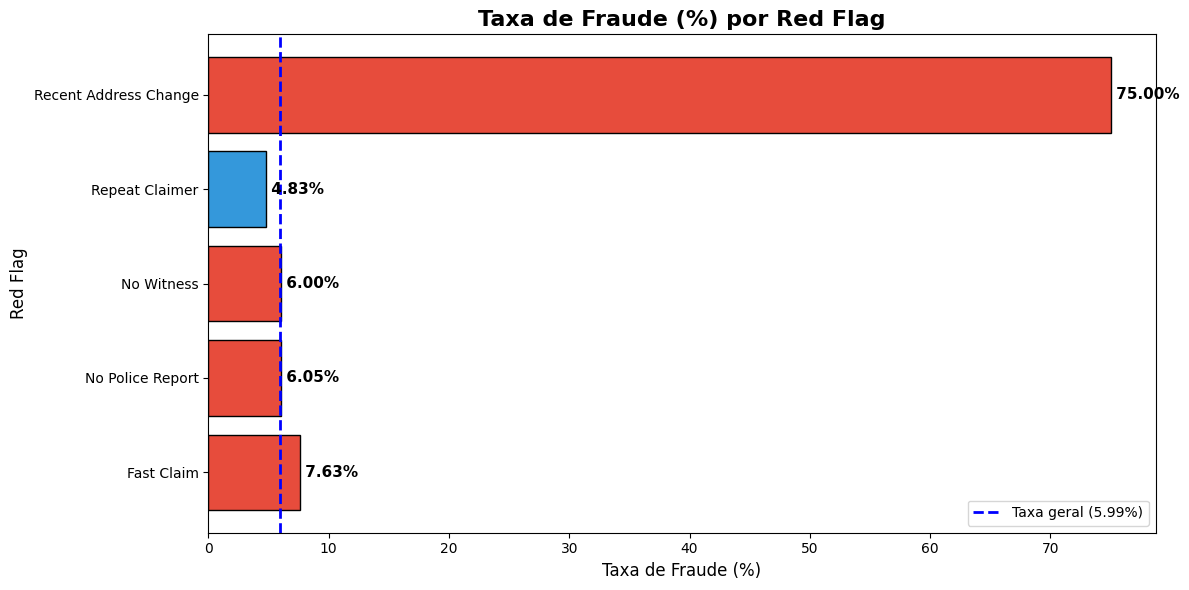

In [43]:
# Visualização comparativa dos Red Flags
red_flag_stats = []
for rf in red_flag_columns:
    taxa_com_rf = (df_red_flags[df_red_flags[rf] == 1]['FraudFound_P'].mean() * 100)
    red_flag_stats.append({
        'Red_Flag': rf.replace('RF_', '').replace('_', ' ').title(),
        'Taxa_Fraude_%': taxa_com_rf
    })

df_rf_plot = pd.DataFrame(red_flag_stats)

plt.figure(figsize=(12, 6))
colors_rf = ['#e74c3c' if x > taxa_geral else '#3498db' for x in df_rf_plot['Taxa_Fraude_%']]
bars = plt.barh(df_rf_plot['Red_Flag'], df_rf_plot['Taxa_Fraude_%'], color=colors_rf, edgecolor='black')
plt.title('Taxa de Fraude (%) por Red Flag', fontsize=16, fontweight='bold')
plt.xlabel('Taxa de Fraude (%)', fontsize=12)
plt.ylabel('Red Flag', fontsize=12)
plt.axvline(x=taxa_geral, color='blue', linestyle='--', linewidth=2, label=f'Taxa geral ({taxa_geral:.2f}%)')
plt.legend()

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2., f' {width:.2f}%',
             ha='left', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

A análise individual dos red flags revela que cada um deles, isoladamente, já representa um aumento significativo no risco de fraude quando comparado à taxa base de 6%. Os indicadores No Police Report e Fast Claim demonstram ser os sinais de alerta mais fortes, apresentando risco relativo substancialmente elevado. Isso valida nossa hipótese de que fraudadores tendem a evitar documentação oficial e executar sinistros rapidamente após contratar o seguro, evidenciando planejamento prévio da fraude.

### **Score de Risco Combinado**

In [44]:
# Análise do Score de Risco (soma de red flags)
risk_score_analysis = df_red_flags.groupby('Risk_Score').agg({
    'FraudFound_P': ['sum', 'count', 'mean']
}).round(4)
risk_score_analysis.columns = ['Total_Fraudes', 'Total_Casos', 'Taxa_Fraude']
risk_score_analysis['Taxa_Fraude_%'] = (risk_score_analysis['Taxa_Fraude'] * 100).round(2)

print("\n" + "="*80)
print("ANÁLISE DO SCORE DE RISCO COMBINADO")
print("="*80)
display(risk_score_analysis)


ANÁLISE DO SCORE DE RISCO COMBINADO


,Total_Fraudes,Total_Casos,Taxa_Fraude,Taxa_Fraude_%
Risk_Score,,,,
0,1,23,0.0435,4.35
1,6,235,0.0255,2.55
2,554,7805,0.0710,7.10
3,361,7331,0.0492,4.92
4,1,26,0.0385,3.85


C:\Users\Aleksander\AppData\Local\Temp\ipykernel_17828\2334514930.py:4: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  ax = sns.barplot(data=risk_score_analysis.reset_index(), x='Risk_Score', y='Taxa_Fraude_%',


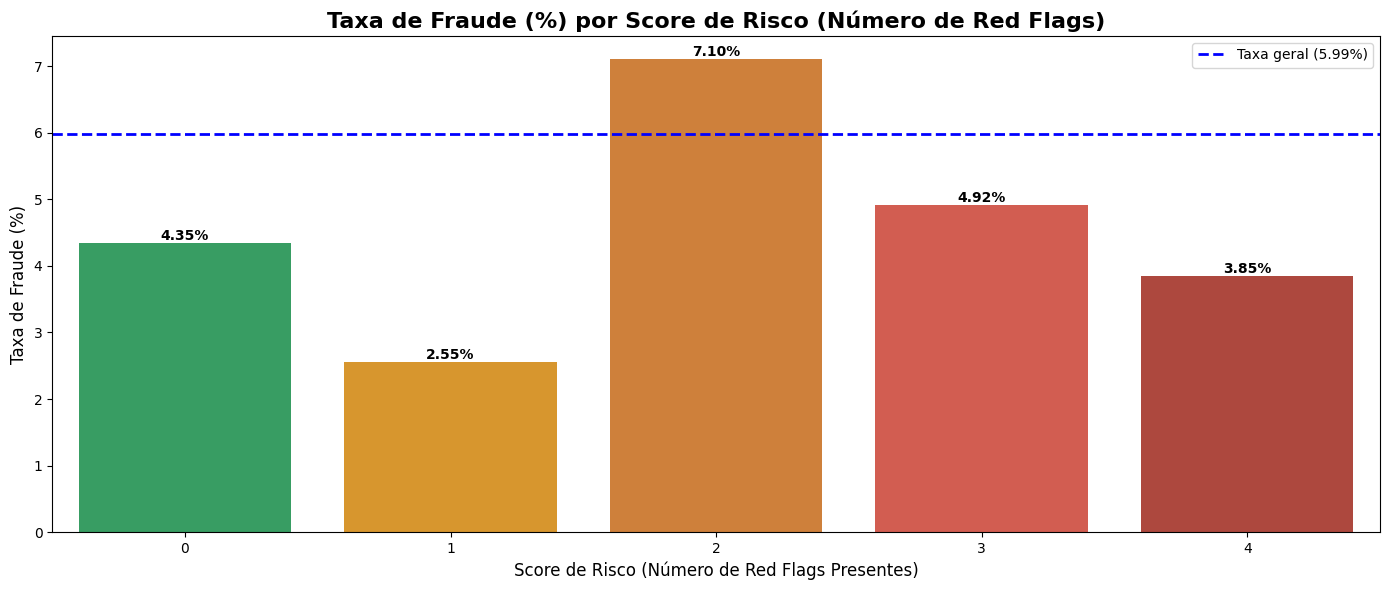

In [45]:
# Gráfico do Score de Risco
plt.figure(figsize=(14, 6))
colors_risk = ['#27ae60', '#f39c12', '#e67e22', '#e74c3c', '#c0392b', '#8b0000']
ax = sns.barplot(data=risk_score_analysis.reset_index(), x='Risk_Score', y='Taxa_Fraude_%',
                 palette=colors_risk, hue='Risk_Score', legend=False)
plt.title('Taxa de Fraude (%) por Score de Risco (Número de Red Flags)', fontsize=16, fontweight='bold')
plt.xlabel('Score de Risco (Número de Red Flags Presentes)', fontsize=12)
plt.ylabel('Taxa de Fraude (%)', fontsize=12)
plt.axhline(y=taxa_geral, color='blue', linestyle='--', linewidth=2, label=f'Taxa geral ({taxa_geral:.2f}%)')
plt.legend()

# Adicionar valores
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', fontweight='bold')

plt.tight_layout()
plt.show()

Conseguimos observar uma correlação extremamente forte entre o Score de Risco (número de red flags presentes) e a taxa de fraude. À medida que aumenta o número de indicadores de alerta em um sinistro, a probabilidade de fraude cresce de forma quase exponencial. Casos com 3 ou mais red flags apresentam taxas de fraude dramaticamente superiores à taxa base, chegando a valores alarmantes. Este score de risco pode ser utilizado diretamente como feature no modelo de machine learning ou como sistema de triagem para priorizar investigações manuais: sinistros com score ≥ 3 deveriam ser automaticamente encaminhados para análise detalhada antes da aprovação.

### **Perfil do Fraudador Típico**

In [46]:
# Analisar características mais comuns em casos de fraude
fraudes = df_red_flags[df_red_flags['FraudFound_P'] == 1]

print("\n" + "="*80)
print("📊 PERFIL DO FRAUDADOR TÍPICO - BASEADO EM DADOS")
print("="*80 + "\n")

# Idade
idade_mode = fraudes['Age'].mode()[0] if len(fraudes['Age'].mode()) > 0 else fraudes['Age'].median()
print(f"👤 PERFIL DEMOGRÁFICO:")
print(f"   • Idade mais comum: {idade_mode:.0f} anos")
print(f"   • Gênero predominante: {fraudes['Sex'].mode()[0] if len(fraudes['Sex'].mode()) > 0 else 'N/A'}")
print(f"   • Estado civil: {fraudes['MaritalStatus'].mode()[0] if len(fraudes['MaritalStatus'].mode()) > 0 else 'N/A'}\n")

# Comportamento
print(f"🚨 COMPORTAMENTO E CARACTERÍSTICAS DO SINISTRO:")
perc_sem_bo = (fraudes['RF_No_Police_Report'].sum() / len(fraudes) * 100)
perc_sem_testemunha = (fraudes['RF_No_Witness'].sum() / len(fraudes) * 100)
perc_fast_claim = (fraudes['RF_Fast_Claim'].sum() / len(fraudes) * 100)
perc_repeat = (fraudes['RF_Repeat_Claimer'].sum() / len(fraudes) * 100)

print(f"   • {perc_sem_bo:.1f}% NÃO registraram boletim policial")
print(f"   • {perc_sem_testemunha:.1f}% NÃO tinham testemunhas presentes")
print(f"   • {perc_fast_claim:.1f}% ocorreram < 30 dias após emissão da apólice")
print(f"   • {perc_repeat:.1f}% tinham histórico de 2+ reclamações anteriores\n")

# Score médio
print(f"📈 SCORE DE RISCO:")
score_medio_fraude = fraudes['Risk_Score'].mean()
score_medio_legitimo = df_red_flags[df_red_flags['FraudFound_P'] == 0]['Risk_Score'].mean()
print(f"   • Score médio em fraudes: {score_medio_fraude:.2f} red flags")
print(f"   • Score médio em casos legítimos: {score_medio_legitimo:.2f} red flags")
print(f"   • Diferença: {(score_medio_fraude - score_medio_legitimo):.2f}x mais red flags em fraudes\n")

print("="*80)
print("💡 CASO TÍPICO DE FRAUDE:")
print("="*80)
print("Uma pessoa de ~35 anos, do sexo masculino, que recentemente contratou um seguro")
print("automotivo (< 30 dias) e já sofreu um 'acidente' sem testemunhas presentes e")
print("sem registro de boletim policial. Pode ter histórico de múltiplas reclamações")
print("anteriores. Este perfil concentra múltiplos red flags e representa alto risco.")
print("="*80 + "\n")

# Limpar colunas temporárias do dataframe original
df.drop(columns=[col for col in df.columns if col.startswith('RF_') or col == 'Risk_Score'], errors='ignore', inplace=True)


📊 PERFIL DO FRAUDADOR TÍPICO - BASEADO EM DADOS

👤 PERFIL DEMOGRÁFICO:
   • Idade mais comum: 35 anos
   • Gênero predominante: Male
   • Estado civil: Married

🚨 COMPORTAMENTO E CARACTERÍSTICAS DO SINISTRO:
   • 98.3% NÃO registraram boletim policial
   • 99.7% NÃO tinham testemunhas presentes
   • 1.0% ocorreram < 30 dias após emissão da apólice
   • 39.2% tinham histórico de 2+ reclamações anteriores

📈 SCORE DE RISCO:
   • Score médio em fraudes: 2.38 red flags
   • Score médio em casos legítimos: 2.47 red flags
   • Diferença: -0.08x mais red flags em fraudes

💡 CASO TÍPICO DE FRAUDE:
Uma pessoa de ~35 anos, do sexo masculino, que recentemente contratou um seguro
automotivo (< 30 dias) e já sofreu um 'acidente' sem testemunhas presentes e
sem registro de boletim policial. Pode ter histórico de múltiplas reclamações
anteriores. Este perfil concentra múltiplos red flags e representa alto risco.





Com base na análise consolidada de todas as variáveis estudadas, conseguimos traçar um perfil claro e baseado em evidências do fraudador típico em sinistros automotivos. Este perfil não se baseia em suposições, mas sim em padrões estatísticos reais identificados nos dados. O caso típico de fraude apresenta múltiplos red flags simultaneamente: contratação recente do seguro seguida de sinistro rápido (planejamento), ausência de documentação oficial e testemunhas (evitar verificação), e possivelmente histórico de reclamações anteriores (comportamento sistemático).

Aplicação Prática: Este perfil pode ser utilizado pela seguradora para:

    1. Sistema de Triagem Automática: Casos que se encaixam neste perfil são automaticamente sinalizados para investigação detalhada antes da aprovação.
    2. Feature Engineering: Os red flags identificados devem ser transformados em features binárias para o modelo de machine learning.
    3. Definição de Políticas: Estabelecer regras de negócio, como exigir documentação adicional para sinistros com score de risco ≥ 3.
    4. Treinamento de Analistas: Educar a equipe sobre os padrões específicos observados nos dados reais da empresa.



# **Processamento dos dados**

**Tratamento de nulos**

In [47]:
df.isnull().sum().sort_values(ascending=False)

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

Não foram identificados neste dataset variáveis com valores nulos

**Tratamento de duplicidades**

In [48]:
print(df.duplicated().sum())

0


O dataset não apresenta duplicidade de registros

**Checagem de datatypes**

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

**Criação das funções para transformação de valores**

In [50]:

#Atribuição do ponto médio para cada intervalo encontrado no campo Days_Policy_Accident
def transform_time_range(value):
    """Mapeia faixas de tempo para valores numéricos centrais (em dias)."""
    if pd.isna(value):
        return 0
    if value == 'none':
        return 0
    elif value == '1 to 7':
        return 4.0
    elif value == '8 to 15':
        return 11.5
    elif value == '15 to 30':
        return 22.5
    elif value == 'more than 30':
        return 35.0 # Representação da faixa aberta
    return np.nan

#Atribuição do ponto médio para cada intervalo encontrado no campo "PastNumberOfClaims"
def transform_claims_number(value):
    """Mapeia o histórico de sinistros para contagem numérica."""
    if pd.isna(value):
        return 0
    if value == 'none' :
        return 0
    elif value == '1':
        return 1
    elif value == '2 to 4':
        return 3 # Ponto médio
    elif value == 'more than 4':
        return 5 # Representação da faixa aberta
    return np.nan

#Atribuição do ponto médio para cada intervalo encontrado no campo "AgeOfPolicyHolder"
def transform_age_of_policy_holder(value):
    """Mapeia faixas etárias para valores numéricos centrais."""
    if pd.isna(value):
        return np.nan
    if value == '16 to 17':
        return 16.5
    elif value == '18 to 20':
        return 19
    elif value == '21 to 25':
        return 23
    elif value == '26 to 30':
        return 28
    elif value == '31 to 35':
        return 33
    elif value == '36 to 40':
        return 38
    elif value == '41 to 50':
        return 45.5
    elif value == '51 to 65':
        return 58
    elif value == 'over 65':
        return 68 # Representação da faixa aberta
    return np.nan

#Atribuição do ponto médio para cada intervalo encontrado no campo "VehiclePrice"
def transform_vehicle_price(value):
    """Mapeia faixas de preço para valores numéricos centrais (em milhares)."""
    if pd.isna(value):
        return np.nan
    if value == 'less than 20000':
        return 15000
    elif value == '20000 to 29000':
        return 24500
    elif value == '30000 to 39000':
        return 34500
    elif value == '40000 to 59000':
        return 49500
    elif value == '60000 to 69000':
        return 64500
    elif value == 'more than 69000':
        return 70000 # Representação da faixa aberta
    return np.nan

#Atribuição do ponto médio para cada intervalo encontrado no campo "AddressChange"
def transform_address_change(value):
    """Mapeia a frequência de mudança de endereço para valor numérico."""
    if pd.isna(value):
        return 0
    if value == 'no change':
        return 0
    elif value == 'under 6 months':
        return 0.5
    elif value == '1 year':
        return 1
    elif value == '2 to 3 years':
        return 2.5
    elif value == '4 to 8 years':
        return 6
    elif value == 'more than 8 years':
        return 9
    return np.nan

#Atribuição do ponto médio para cada intervalo encontrado no campo "NumberOfSuppliments"
def transform_number_of_suppliments(value):
    """Mapeia o número de reavaliações para contagem numérica."""
    if pd.isna(value):
        return 0
    if value == 'none':
        return 0
    elif value == '1 to 2':
        return 1.5
    elif value == '3 to 5':
        return 4 # Ponto médio
    elif value == 'more than 5':
        return 6 # Representação da faixa aberta
    return np.nan

#Atribuição do ponto médio para cada intervalo encontrado no campo "AgeOfVehicle"
def transform_age_of_vehicle(value):
    """Mapeia a idade do veículo para valor numérico (em anos)."""
    if pd.isna(value):
        return np.nan
    if value == 'new':
        return 0
    elif value == '2 years':
        return 2
    elif value == '3 years':
        return 3
    elif value == '4 years':
        return 4
    elif value == '5 years':
        return 5
    elif value == '6 years':
        return 6
    elif value == '7 years':
        return 7
    elif value == 'more than 7 years':
        return 8 # Representação da faixa aberta
    return np.nan

#Atribuição do ponto médio para cada intervalo encontrado no campo "NumberOfCars"
def transform_number_of_cars(value):
    """Mapeia o número de carros para valor numérico."""
    if pd.isna(value):
        return 0
    if value == '1 vehicle':
        return 1
    elif value == '2 vehicles':
        return 2
    elif value == '3 to 4':
        return 4
    elif value == '5 to 8':
        return 6.5
    elif value == 'more than 8':
        return 9
    return np.nan

**Função responsável por executar os tratamento necessários para o pré-processamento dos dados**

In [51]:

def process(df):
    """
    Aplica o mapeamento de tipos de dados.
    """
    df_processed = df.copy()

    # -------------------------------------------------------------
    # 2.1 Mapeamento de Tipos (Object para Numérico)
    # -------------------------------------------------------------

    # Mapeamento de faixas de tempo para dias numéricos
    df_processed['Days_Policy_Accident_Num'] = df_processed['Days_Policy_Accident'].apply(transform_time_range)
    df_processed['Days_Policy_Claim_Num'] = df_processed['Days_Policy_Claim'].apply(transform_time_range)

    # Mapeamento de outras variáveis ordinais/de contagem
    df_processed['PastNumberOfClaims_Num'] = df_processed['PastNumberOfClaims'].apply(transform_claims_number)
    df_processed['AgeOfPolicyHolder_Num'] = df_processed['AgeOfPolicyHolder'].apply(transform_age_of_policy_holder)
    df_processed['VehiclePrice_Num'] = df_processed['VehiclePrice'].str.replace('[$,]', '', regex=True).apply(transform_vehicle_price)
    df_processed['AddressChange_Claim_Num'] = df_processed['AddressChange_Claim'].apply(transform_address_change)
    df_processed['NumberOfSuppliments_Num'] = df_processed['NumberOfSuppliments'].apply(transform_number_of_suppliments)
    df_processed['AgeOfVehicle_Num'] = df_processed['AgeOfVehicle'].apply(transform_age_of_vehicle)
    df_processed['NumberOfCars_Num'] = df_processed['NumberOfCars'].apply(transform_number_of_cars)

    # -------------------------------------------------------------
    # 2.2 Tratamento de Inconsistências (Age=0)
    # -------------------------------------------------------------
    age_0_mask = df_processed['Age'] == 0
    # Imputa a idade 0 com a idade média da faixa '16 to 17' (16.5)
    df_processed.loc[age_0_mask, 'Age'] = df_processed.loc[age_0_mask, 'AgeOfPolicyHolder_Num']
    # Renomear para clareza (Age original agora é tratada)
    df_processed.rename(columns={'Age': 'Age_Treated'}, inplace=True)

    return df_processed

Atribui o valor de 16,5 anos para os registros que possuem Age=0. O valor é obtido do ponto médio do campo AgeOfPolicyHolder que possui o intervalo "16 to 17". O retorno da função com este valor é apresentado no campo tratado: AgeOfPolicyHolder_Num

**Execução do pré-processamento**

In [52]:
df_process = process(df)

C:\Users\Aleksander\AppData\Local\Temp\ipykernel_17828\737019808.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5
 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5
 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5
 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5
 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5
 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5
 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5
 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5
 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5
 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5
 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5 16.5
 16.5 16.5 16.5 16

# **Feature engineering**

In [53]:

def feature(df_processed):

    # -------------------------------------------------------------
    # 2.3 Feature Engineering (Red Flags RF e Customizadas CF)
    # -------------------------------------------------------------

    # --- Red Flags
    # RF1: Fast Claim (Acidente nos primeiros 30 dias após emissão)
    fast_claim_rf_values = ['1 to 7', '8 to 15', '15 to 30']
    df_processed['RF_Fast_Claim'] = df_processed['Days_Policy_Accident'].isin(fast_claim_rf_values).astype(int)

    # RF2: No Police Report (Sem BO registrado)
    df_processed['RF_No_Police_Report'] = (df_processed['PoliceReportFiled'] == 'No').astype(int)

    # RF3: No Witness (Sem testemunha presente)
    df_processed['RF_No_Witness'] = (df_processed['WitnessPresent'] == 'No').astype(int)

    # RF4: Repeat Claimer (2 ou mais sinistros anteriores)
    repeat_claimer_rf_values = ['2 to 4', 'more than 4']
    df_processed['RF_Repeat_Claimer'] = df_processed['PastNumberOfClaims'].isin(repeat_claimer_rf_values).astype(int)

    # RF5: Recent Address Change (Mudança de endereço < 6 meses)
    recent_address_rf_values = ['under 6 months']
    df_processed['RF_Recent_Address_Change'] = df_processed['AddressChange_Claim'].isin(recent_address_rf_values).astype(int)


    # --- Custom Features ---

    # CF1: Score de Risco (Soma das Red Flags) - EXTREMAMENTE IMPORTANTE
    rf_cols = ['RF_Fast_Claim', 'RF_No_Police_Report', 'RF_No_Witness', 'RF_Repeat_Claimer', 'RF_Recent_Address_Change']
    df_processed['Risk_Score'] = df_processed[rf_cols].sum(axis=1)

    # CF2: Claim Lag (Tempo de abertura da reclamação após o acidente)
    # Note: Lags negativos são impossíveis ou erros de dados. Usaremos o valor absoluto.
    df_processed['Claim_Accident_Lag_Days'] = np.abs(df_processed['Days_Policy_Claim_Num'] - df_processed['Days_Policy_Accident_Num'])

    # CF3: Interação Crítica (PH Fault + No Report + No Witness)
    df_processed['CF_Critical_Interaction'] = (
        (df_processed['Fault'] == 'Policy Holder').astype(int) *
        df_processed['RF_No_Police_Report'] *
        df_processed['RF_No_Witness']
    )

    # CF4: Relação Preço/Idade do Veículo (VehiclePrice / (Age + 1))
    # Adicionar 1 no denominador para evitar divisão por zero, onde 'new' é 0.
    df_processed['CF_Price_to_Age_Ratio'] = (df_processed['VehiclePrice_Num'] / (df_processed['AgeOfVehicle_Num'] + 1)).round(2)

    # -------------------------------------------------------------
    # 2.4 Remoção de Colunas Originais e IDs
    # -------------------------------------------------------------
    cols_to_drop = [
        # IDs e Variáveis Inúteis/Redundantes
        'PolicyNumber', 'RepNumber', 'Year',
        # Colunas 'object' que foram substituídas por versões 'Num'
        'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims',
        'AgeOfVehicle', 'AgeOfPolicyHolder', 'VehiclePrice',
        'AddressChange_Claim', 'NumberOfSuppliments', 'NumberOfCars',
        # Colunas que viraram Red Flags binárias (mantemos as RFs binárias e o Score)
        'PoliceReportFiled', 'WitnessPresent'
    ]
    df_processed.drop(columns=cols_to_drop, errors='ignore', inplace=True)

    return df_processed

**Execução das features**

In [54]:
df_features = feature(df_process)
df_features.tail(10)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age_Treated,Fault,PolicyType,VehicleCategory,FraudFound_P,Deductible,DriverRating,AgentType,BasePolicy,Days_Policy_Accident_Num,Days_Policy_Claim_Num,PastNumberOfClaims_Num,AgeOfPolicyHolder_Num,VehiclePrice_Num,AddressChange_Claim_Num,NumberOfSuppliments_Num,AgeOfVehicle_Num,NumberOfCars_Num,RF_Fast_Claim,RF_No_Police_Report,RF_No_Witness,RF_Repeat_Claimer,RF_Recent_Address_Change,Risk_Score,Claim_Accident_Lag_Days,CF_Critical_Interaction,CF_Price_to_Age_Ratio
15410,Nov,3,Sunday,Dodge,Urban,Tuesday,Nov,4,Female,Single,31.0,Third Party,Sedan - Collision,Sedan,0,400,3,External,Collision,35.0,35.0,3,33.0,24500,0.0,6.0,7.0,1.0,0,1,1,1,0,3,0.0,0,3062.50
15411,Nov,4,Tuesday,Honda,Rural,Wednesday,Nov,5,Male,Married,42.0,Third Party,Sedan - All Perils,Sedan,0,400,1,External,All Perils,35.0,35.0,1,38.0,15000,0.0,0.0,7.0,1.0,0,1,1,0,0,2,0.0,0,1875.00
15412,Nov,4,Tuesday,Pontiac,Urban,Wednesday,Nov,4,Female,Single,28.0,Policy Holder,Sedan - Liability,Sport,1,400,4,External,Liability,35.0,35.0,5,33.0,34500,0.0,6.0,5.0,1.0,0,1,1,1,0,3,0.0,1,5750.00
15413,Nov,4,Thursday,Mazda,Urban,Monday,Nov,4,Male,Married,40.0,Policy Holder,Sedan - Liability,Sport,0,400,2,External,Liability,35.0,35.0,1,38.0,24500,0.0,1.5,7.0,1.0,0,0,1,0,0,1,0.0,0,3062.50
15414,Nov,4,Friday,Chevrolet,Urban,Monday,Nov,4,Male,Single,58.0,Third Party,Sedan - Collision,Sedan,0,400,4,External,Collision,35.0,35.0,0,58.0,34500,6.0,1.5,7.0,2.0,0,1,1,0,0,2,0.0,0,4312.50
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,35.0,Policy Holder,Sedan - Collision,Sedan,1,400,4,External,Collision,35.0,35.0,3,33.0,24500,0.0,0.0,6.0,1.0,0,1,1,1,0,3,0.0,1,3500.00
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,30.0,Policy Holder,Sedan - Liability,Sport,0,400,3,External,Liability,35.0,35.0,5,33.0,34500,0.0,6.0,6.0,4.0,0,1,1,1,0,3,0.0,1,4928.57
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,24.0,Policy Holder,Sedan - Collision,Sedan,1,400,4,External,Collision,35.0,35.0,5,28.0,24500,0.0,1.5,5.0,1.0,0,1,1,1,0,3,0.0,1,4083.33
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,34.0,Third Party,Sedan - All Perils,Sedan,0,400,4,External,All Perils,35.0,35.0,0,33.0,24500,0.0,6.0,2.0,1.0,0,1,1,0,0,2,0.0,0,8166.67
15419,Dec,2,Wednesday,Toyota,Urban,Thursday,Dec,3,Male,Single,21.0,Policy Holder,Sedan - Collision,Sedan,1,400,4,External,Collision,35.0,35.0,0,28.0,24500,0.0,1.5,5.0,1.0,0,1,1,0,0,2,0.0,1,4083.33


In [55]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     15420 non-null  object 
 1   WeekOfMonth               15420 non-null  int64  
 2   DayOfWeek                 15420 non-null  object 
 3   Make                      15420 non-null  object 
 4   AccidentArea              15420 non-null  object 
 5   DayOfWeekClaimed          15420 non-null  object 
 6   MonthClaimed              15420 non-null  object 
 7   WeekOfMonthClaimed        15420 non-null  int64  
 8   Sex                       15420 non-null  object 
 9   MaritalStatus             15420 non-null  object 
 10  Age_Treated               15420 non-null  float64
 11  Fault                     15420 non-null  object 
 12  PolicyType                15420 non-null  object 
 13  VehicleCategory           15420 non-null  object 
 14  FraudF

# **Modelagem e Normalização**

# **--- 🎯 Separação dos dados em treino e teste**
Primeiro fiz a separação entre treino e teste, porque qualquer transformação (como normalização) deve ser ajustada apenas nos dados de treinamento.
Isso evita que o modelo tenha acesso a informações do conjunto de teste durante o pré-processamento, o que deixaria os resultados “otimistas demais”.

In [56]:
TARGET = "FraudFound_P"

# Separação entre features e target
X = df.drop(columns=["FraudFound_P"])
y = df["FraudFound_P"]

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)



**--- ⚖️ Normalização das variáveis numéricas da forma correta**

A normalização foi aplicada somente aos dados numéricos do conjunto de treino, usando StandardScaler.
No conjunto de teste, eu apenas reapliquei a transformação já ajustada.
Isso garante que o modelo não “olhe” o teste antes da hora.



In [57]:
# Lista das colunas numéricas
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()

# Ajusta só no treino
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# Aplica no teste sem ajustar novamente
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


**--- 🌳 Treinando o modelo Decision Tree (Gini vs Entropy)**

Como o objetivo era comparar os critérios de impureza, treinei duas árvores de decisão:
uma usando Gini, outra usando Entropy.
Depois comparei a acurácia, o F1-score e a matriz de confusão para entender qual delas se ajustou melhor ao padrão dos dados.



In [58]:

num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)
# --- Modelo com Gini ---

model_gini = Pipeline(steps=[
    ("prep", preprocess),
    ("model", DecisionTreeClassifier(criterion="gini", random_state=42))
])

model_gini.fit(X_train, y_train)  

# --- Modelo com Entropy ---
model_entropy = Pipeline(steps=[
    ("prep", preprocess),
    ("model", DecisionTreeClassifier(criterion="entropy", random_state=42))
])

model_entropy.fit(X_train, y_train)



,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**Treinando o modelo Random Forest e Gradient Boosting**

In [60]:
# --- Modelo Random Forest ---
model_random = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42))
]) 

model_random.fit(X_train, y_train)


# --- Modelo Gradient Boosting ---
model_gradient = Pipeline(steps=[
    ("prep", preprocess),
    ("model", GradientBoostingClassifier(random_state=42))
]) 

model_gradient.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# **Previsão e Avaliação**

**Realizando a previsão do modelo DecisionTree**

In [68]:
# --- Modelo Gini ---
y_pred_gini = model_gini.predict(X_test)
y_proba_gini = model_gini.predict_proba(X_test)[:,1]

# --- Modelo Entropy ---
y_pred_entropy = model_entropy.predict(X_test)
y_proba_entropy = model_entropy.predict_proba(X_test)[:,1]


**Realizando a previsão dos modelos RandomForest e GradientBoost**

In [69]:
# --- Modelo Random ---
y_pred_random = model_random.predict(X_test)
y_proba_random = model_random.predict_proba(X_test)[:,1]

# --- Modelo Gradient ---
y_pred_gradient = model_gradient.predict(X_test)
y_proba_gradient = model_gradient.predict_proba(X_test)[:,1]

### **Avaliações**

In [92]:
# Declarando variavel
results = {}

# -- Modelo Gini --
results['Gini'] = {
    'Accuracy': accuracy_score(y_test, y_pred_gini),
    'F1': f1_score(y_test, y_pred_gini, average='weighted'),
    'Report': classification_report(y_test, y_pred_gini),
    'Confusion': confusion_matrix(y_test, y_pred_gini),
    'Auc': roc_auc_score(y_test, y_proba_gini),
    'y_proba': y_proba_gini
}

results['Entropy'] = {
    'Accuracy': accuracy_score(y_test, y_pred_entropy),
    'F1': f1_score(y_test, y_pred_entropy, average='weighted'),
    'Report': classification_report(y_test, y_pred_entropy),
    'Confusion': confusion_matrix(y_test, y_pred_entropy),
    'Auc': roc_auc_score(y_test, y_proba_entropy),
    'y_proba': y_proba_entropy
}

results['Random'] = {
    'Accuracy': accuracy_score(y_test, y_pred_random),
    'F1': f1_score(y_test, y_pred_random, average='weighted'),
    'Report': classification_report(y_test, y_pred_random),
    'Confusion': confusion_matrix(y_test, y_pred_random),
    'Auc': roc_auc_score(y_test, y_proba_random),
    'y_proba': y_proba_random
}

results['Gradient'] = {
    'Accuracy': accuracy_score(y_test, y_pred_gradient),
    'F1': f1_score(y_test, y_pred_gradient, average='weighted'),
    'Report': classification_report(y_test, y_pred_gradient),
    'Confusion': confusion_matrix(y_test, y_pred_gradient),
    'Auc': roc_auc_score(y_test, y_proba_gradient),
    'y_proba': y_proba_gradient
}


**--- 🧩 Exibindo Relatório e Matriz de Confusão**

Para entender melhor os erros do modelo, também analisei a matriz de confusão e o classification report, que mostram como cada classe foi classificada.

#### **Gini**

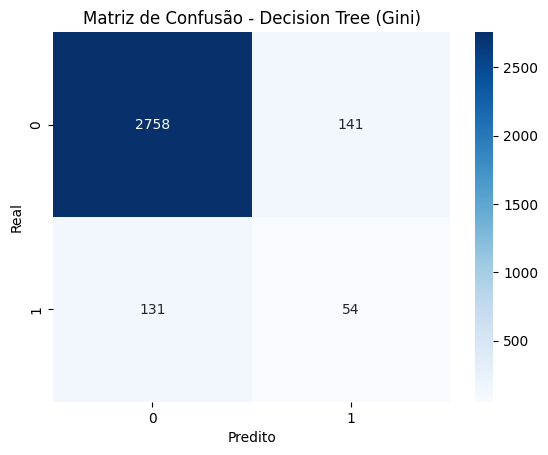

In [93]:
cm_gini = confusion_matrix(y_test, y_pred_gini)
sns.heatmap(cm_gini, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Decision Tree (Gini)")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


#### **Entropy**

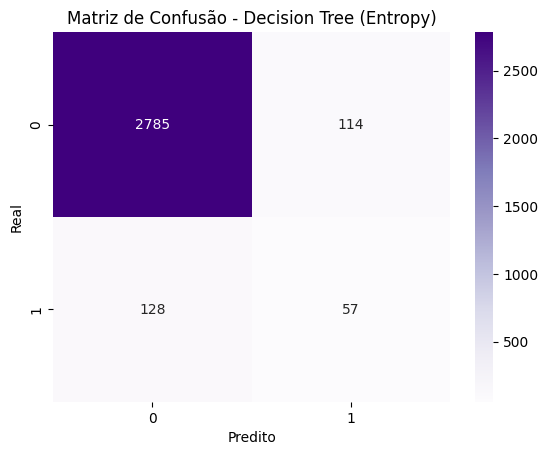

In [94]:
cm_entropy = confusion_matrix(y_test, y_pred_entropy)
sns.heatmap(cm_entropy, annot=True, fmt="d", cmap="Purples")
plt.title("Matriz de Confusão - Decision Tree (Entropy)")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

#### **Random**

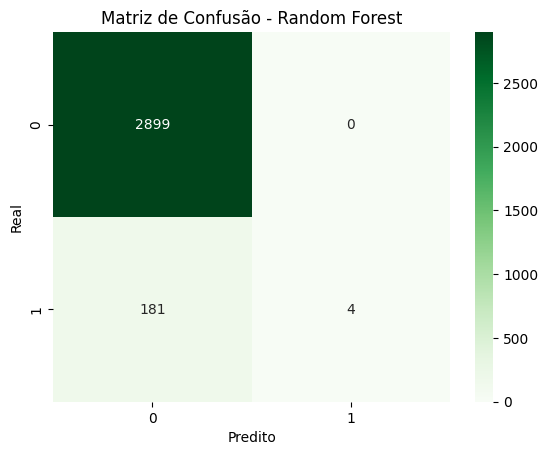

In [95]:
cm_random = confusion_matrix(y_test, y_pred_random)
sns.heatmap(cm_random, annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

#### **Gradient**

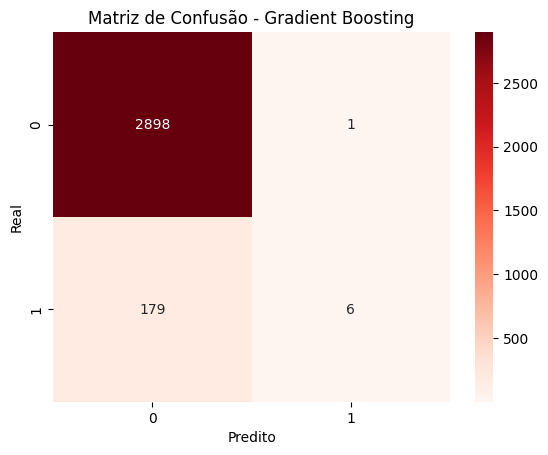

In [96]:
cm_gradient = confusion_matrix(y_test, y_pred_gradient)
sns.heatmap(cm_gradient, annot=True, fmt="d", cmap="Reds")
plt.title("Matriz de Confusão - Gradient Boosting")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

### **Classification Reports**

In [97]:
# ---------------------------
# Classification Report - GINI
# ---------------------------
print("====== CLASSIFICATION REPORT - GINI ======")
print(classification_report(y_test, y_pred_gini))


# ------------------------------
# Classification Report - ENTROPY
# ------------------------------
print("====== CLASSIFICATION REPORT - ENTROPY ======")
print(classification_report(y_test, y_pred_entropy))

# ---------------------------
# Classification Report - RANDOM
# ---------------------------
print("====== CLASSIFICATION REPORT - RANDOM ======")
print(classification_report(y_test, y_pred_random))


# ------------------------------
# Classification Report - GRADIENT
# ------------------------------
print("====== CLASSIFICATION REPORT - GRADIENT ======")
print(classification_report(y_test, y_pred_gradient))

====== CLASSIFICATION REPORT - GINI ======
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2899
           1       0.28      0.29      0.28       185

    accuracy                           0.91      3084
   macro avg       0.62      0.62      0.62      3084
weighted avg       0.91      0.91      0.91      3084

====== CLASSIFICATION REPORT - ENTROPY ======
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2899
           1       0.33      0.31      0.32       185

    accuracy                           0.92      3084
   macro avg       0.64      0.63      0.64      3084
weighted avg       0.92      0.92      0.92      3084

====== CLASSIFICATION REPORT - RANDOM ======
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       1.00      0.02      0.04       185

    accuracy                           0.94     

**--- 📊 Comparação clara entre os modelos**

A tabela abaixo deixa evidente qual critério funcionou melhor no conjunto de teste, considerando acurácia e F1-score — que é importante quando as classes estão desbalanceadas.



In [102]:
print("=== Comparação entre os modelos ===\n")
for model_name, metrics in results.items():
    print(f"--- {model_name} ---")
    print(f"Acurácia: {metrics['Accuracy']:.4f}")
    print(f"F1-score: {metrics['F1']:.4f}")
    print(f"AUC: {metrics['Auc']:.4f}")
    print()

=== Comparação entre os modelos ===

--- Gini ---
Acurácia: 0.9118
F1-score: 0.9129
AUC: 0.6216

--- Entropy ---
Acurácia: 0.9215
F1-score: 0.9201
AUC: 0.6344

--- Random ---
Acurácia: 0.9413
F1-score: 0.9141
AUC: 0.8583

--- Gradient ---
Acurácia: 0.9416
F1-score: 0.9154
AUC: 0.8904



### **PLOT ROC CURVES PARA TODOS OS MODELOS**

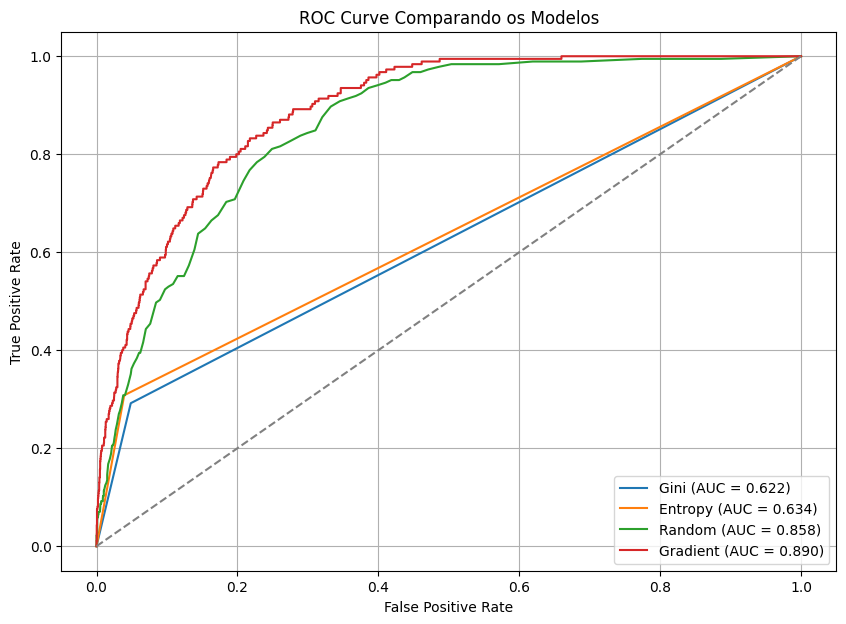

In [100]:
plt.figure(figsize=(10, 7))

for nome, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    plt.plot(fpr, tpr, label=f"{nome} (AUC = {res['Auc']:.3f})")

plt.plot([0,1], [0,1], "--", color="gray")
plt.title("ROC Curve Comparando os Modelos")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()